# Stock index prediction

This project uses popular stock market indexes to predict S&P500 returns. The algorithms used are support vector machines and feed forward neural nets. Before the predictions, the data are cleaned, features are engineered, and smaller data sets with relevant features are created.

#### 1. Data cleaning

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="white")

from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectPercentile, f_classif, chi2, mutual_info_classif

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import np_utils
from keras import optimizers

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [2]:
# load data

cac40 = pd.read_csv('./data/^CAC.csv')
dax = pd.read_csv('./data/^DAX.csv')
hsi = pd.read_csv('./data/^HSI.csv')
nikkei225 = pd.read_csv('./data/^N225.csv')
sp500 = pd.read_csv('./data/^SP500.csv')
nasdaq = pd.read_csv('./data/^NASDC.csv')
dji = pd.read_csv('./data/^DJI.csv')
eurostx = pd.read_csv('./data/eurostx.csv')
ftse100 = pd.read_csv('./data/ftse100.csv')
sh_comp = pd.read_csv('./data/shanghai_composite.csv')
asx200 = pd.read_csv('./data/asx200.csv')

all_indexes = [cac40, dax, hsi, nikkei225, sp500, nasdaq, dji, eurostx, ftse100, sh_comp, asx200]

In [3]:
# drop unnecessary columns and NAs

cac40 = cac40.dropna(axis=0, how='any')
dax = dax.dropna(axis=0, how='any')
hsi = hsi.dropna(axis=0, how='any')
nikkei225 = nikkei225.dropna(axis=0, how='any')
sp500 = sp500.dropna(axis=0, how='any')
nasdaq = nasdaq.dropna(axis=0, how='any')
dji = dji.dropna(axis=0, how='any')
eurostx = eurostx.dropna(axis=0, how='any')
ftse100 = ftse100.dropna(axis=0, how='any')
sh_comp = sh_comp.dropna(axis=0, how='any')
asx200 = asx200.dropna(axis=0, how='any')

eurostx = eurostx.drop('Unnamed: 0', 1)
ftse100 = ftse100.drop('Unnamed: 0', 1)
sh_comp = sh_comp.drop('Unnamed: 0', 1)
asx200 = asx200.drop('Unnamed: 0', 1)

In [4]:
# convert all date columns to date format

cac40['Date'] = pd.to_datetime(cac40['Date'])
dax['Date'] = pd.to_datetime(dax['Date'])
hsi['Date'] = pd.to_datetime(hsi['Date'])
nikkei225['Date'] = pd.to_datetime(nikkei225['Date'])
sp500['Date'] = pd.to_datetime(sp500['Date'])
nasdaq['Date'] = pd.to_datetime(nasdaq['Date'])
dji['Date'] = pd.to_datetime(dji['Date'])
eurostx['Date'] = pd.to_datetime(eurostx['Date'])
ftse100['Date'] = pd.to_datetime(ftse100['Date'])
sh_comp['Date'] = pd.to_datetime(sh_comp['Date'])
asx200['Date'] = pd.to_datetime(asx200['Date'])

In [5]:
# change column names

cac40.rename(columns={ 'Close' : 'cac40'}, inplace=True)
dax.rename(columns={ 'Close' : 'dax'}, inplace=True)
hsi.rename(columns={ 'Close' : 'hsi'}, inplace=True)
nikkei225.rename(columns={ 'Close' : 'nikkei225'}, inplace=True)
sp500.rename(columns={ 'Close' : 'sp500'}, inplace=True)
nasdaq.rename(columns={ 'Close' : 'nasdaq'}, inplace=True)
dji.rename(columns={ 'Close' : 'dji'}, inplace=True)
eurostx.rename(columns={ 'Close' : 'eurostx'}, inplace=True)
ftse100.rename(columns={ 'Close' : 'ftse100'}, inplace=True)
sh_comp.rename(columns={ 'Close' : 'sh_comp'}, inplace=True)
asx200.rename(columns={ 'Close' : 'asx200'}, inplace=True)

In [6]:
# remove unnecassry columns

drop = ['Open', 'High', 'Low', 'Adj Close', 'Volume']

cac40.drop(drop, axis=1, inplace=True)
dax.drop(drop, axis=1, inplace=True)
hsi.drop(drop, axis=1, inplace=True)
nikkei225.drop(drop, axis=1, inplace=True)
sp500.drop(drop, axis=1, inplace=True)
nasdaq.drop(drop, axis=1, inplace=True)
dji.drop(drop, axis=1, inplace=True)

drop2 = ['Open', 'High', 'Low', 'Volume']

eurostx.drop(drop2, axis=1, inplace=True)
ftse100.drop(drop2, axis=1, inplace=True)
sh_comp.drop(drop2, axis=1, inplace=True)
asx200.drop(drop2, axis=1, inplace=True)

In [7]:
# merge data using longest data frame first

temp = pd.merge(eurostx, ftse100, how='inner', on='Date')
temp1 = pd.merge(temp, cac40, how='inner', on='Date')
temp2 = pd.merge(temp1, sh_comp, how='inner', on='Date')
temp3 = pd.merge(temp2, sp500, how='inner', on='Date')
temp4 = pd.merge(temp3, asx200, how='inner', on='Date')
temp5 = pd.merge(temp4, nasdaq, how='inner', on='Date')
temp6 = pd.merge(temp5, dji, how='inner', on='Date')
temp7 = pd.merge(temp6, hsi, how='inner', on='Date')
temp8 = pd.merge(temp7, dax, how='inner', on='Date')
temp9 = pd.merge(temp8, nikkei225, how='inner', on='Date')

In [8]:
# find indexes where value is 'null' and drop those rows
index = []
for i in range(1,len(temp9.columns)):
    temp10 = temp9.iloc[:, i]
    for j in range(len(temp10)):
        if temp10[j] == 'null':
            index.append(j)
            
data = temp9.drop(temp.index[index])
data = data[::-1].reset_index(drop=True)

In [9]:
# convert index to date index and ensure all data are numeric

data['Date'] = pd.to_datetime(data['Date'])
data.index = data['Date']
del data['Date']

data = data.apply(pd.to_numeric, errors='ignore')

data.head()

eurostx  ftse100        cac40  sh_comp        sp500  asx200  \
Date                                                                      
2012-08-24  2434.23  5776.60  3433.209961  2092.10  1411.130005  4349.0   
2012-08-28  2442.12  5775.71  3431.550049  2073.15  1409.300049  4359.4   
2012-08-29  2434.23  5743.53  3413.889893  2053.23  1410.489990  4356.4   
2012-08-30  2403.80  5719.45  3379.110107  2052.58  1399.479980  4315.7   
2012-08-31  2440.71  5711.48  3413.070068  2047.52  1406.579956  4316.1   

                 nasdaq           dji           hsi          dax    nikkei225  
Date                                                                           
2012-08-24  3069.790039  13157.969727  19880.029297  6971.069824  9070.759766  
2012-08-28  3077.139893  13102.990234  19811.800781  7002.680176  9033.290039  
2012-08-29  3081.189941  13107.480469  19788.509766  7010.569824  9069.809570  
2012-08-30  3048.709961  13000.709961  19552.910156  6895.490234  8983.780273  
2012-08-31  3066.959961  13090.839844  19482.570313  6970.790039  8839.910156

In [10]:
print('The combined data has {} rows and {} columns.'.format(data.shape[0], data.shape[1]))

The combined data has 1055 rows and 11 columns.


#### 2. Data exploration

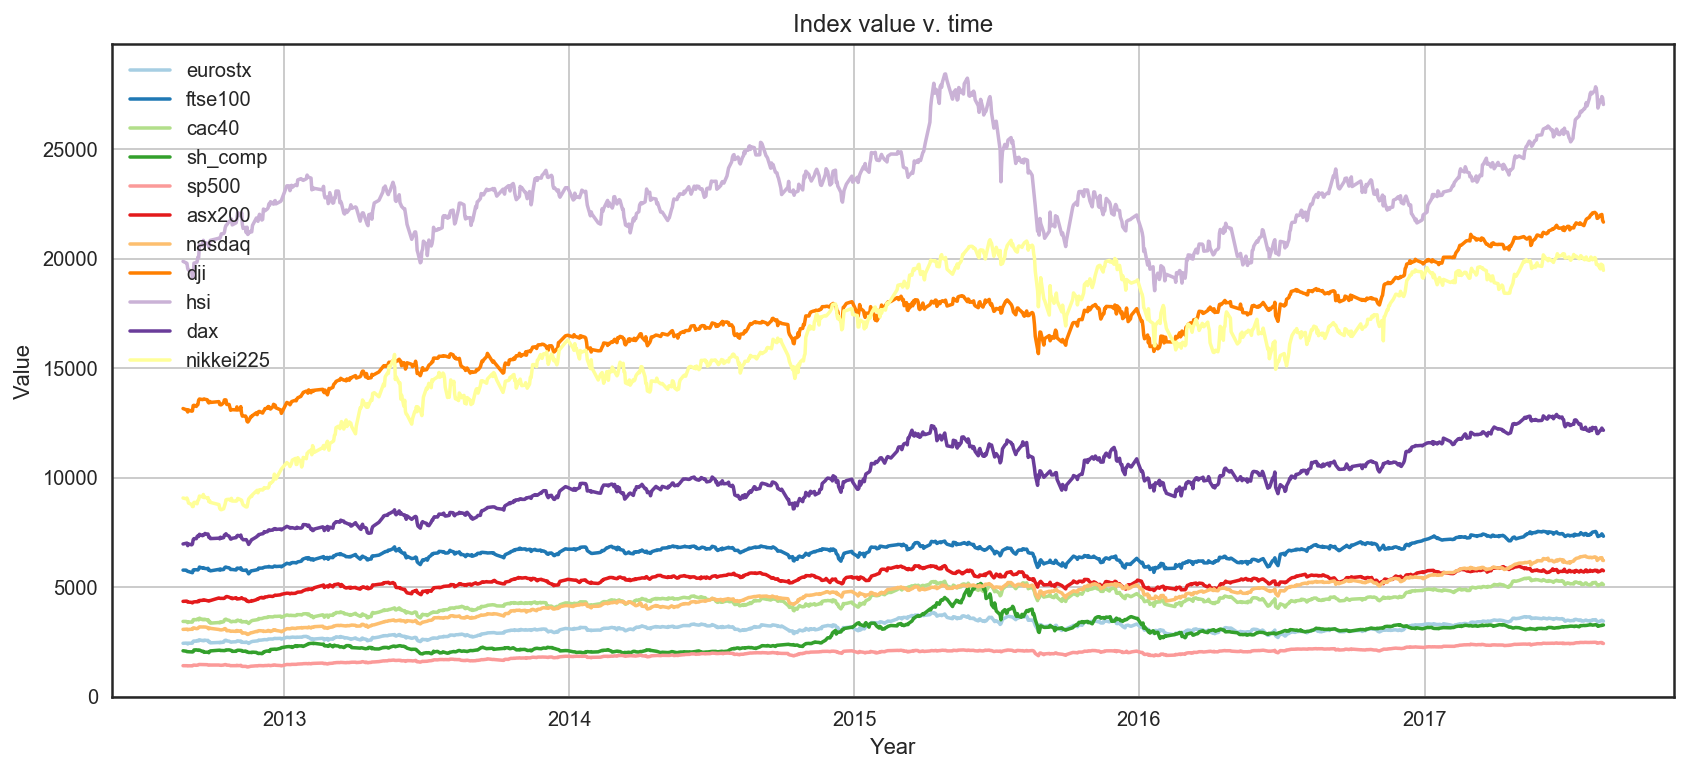

In [11]:
# regular line plot
plt.figure(figsize=(14,6))
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99']
for i in range(len(data.columns)):
    plt.plot(data.iloc[:, i], color=colors[i]);
    plt.legend(loc='best');
plt.grid();
plt.xlabel('Year');
plt.ylabel('Value');
plt.title('Index value v. time');
plt.show();

Analysis:

- all indexes have increased over the past 5 years
- the nikkei 225 composite appears to have increased the most
- the 6 indexes at the bottom (sp500, eurostx, nasdaq, cac40, ftse100, asx200) have seen the least growth but have grown at a steady pace compared to others
- the hang seng index shows a big dip around mid 2015
- the dji show strong and steady growth

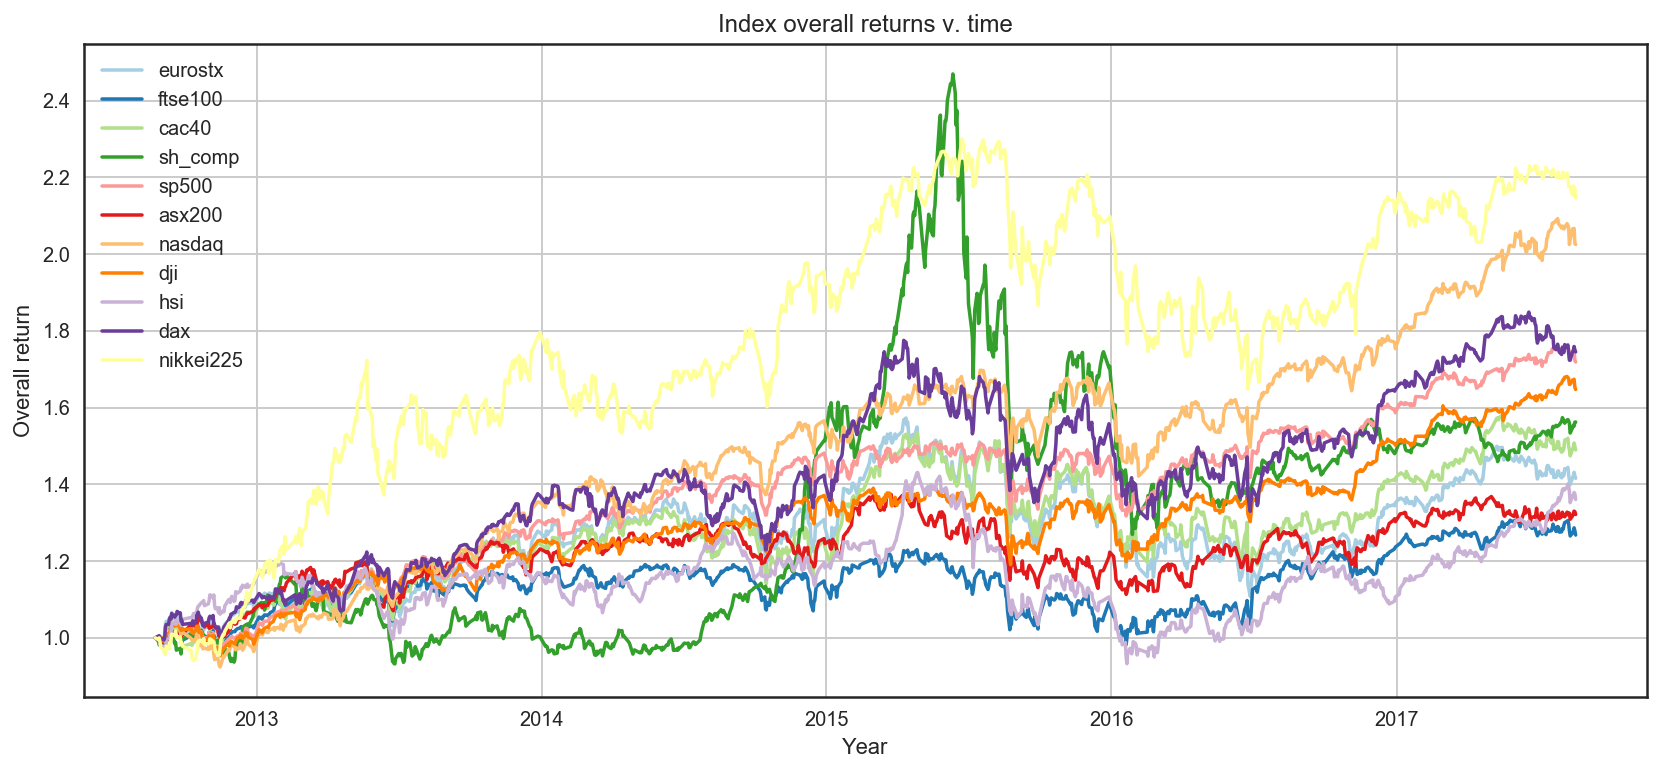

In [12]:
# regular line plot starting at 0
data_norm = data.copy(deep=True)

for column in data_norm.columns:
    data_norm[column] = data_norm[column] / data_norm[column][0]
    
plt.figure(figsize=(14,6))
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99']
for i in range(len(data_norm.columns)):
    plt.plot(data_norm.iloc[:, i], color=colors[i])
    plt.legend(loc='best')

plt.grid()
plt.xlabel('Year')
plt.ylabel('Overall return')
plt.title('Index overall returns v. time')
plt.show()

Analysis:

- shows that the nikkei 225 increased the most
- shows high levels of correlation, especially for nasdaq, dax, sp500, dji
- shanghai composite showed the most variance over the 5 years

In [13]:
# create a dataframe with returns
data_returns = data.pct_change(periods=1)
data_returns.dropna(inplace=True)

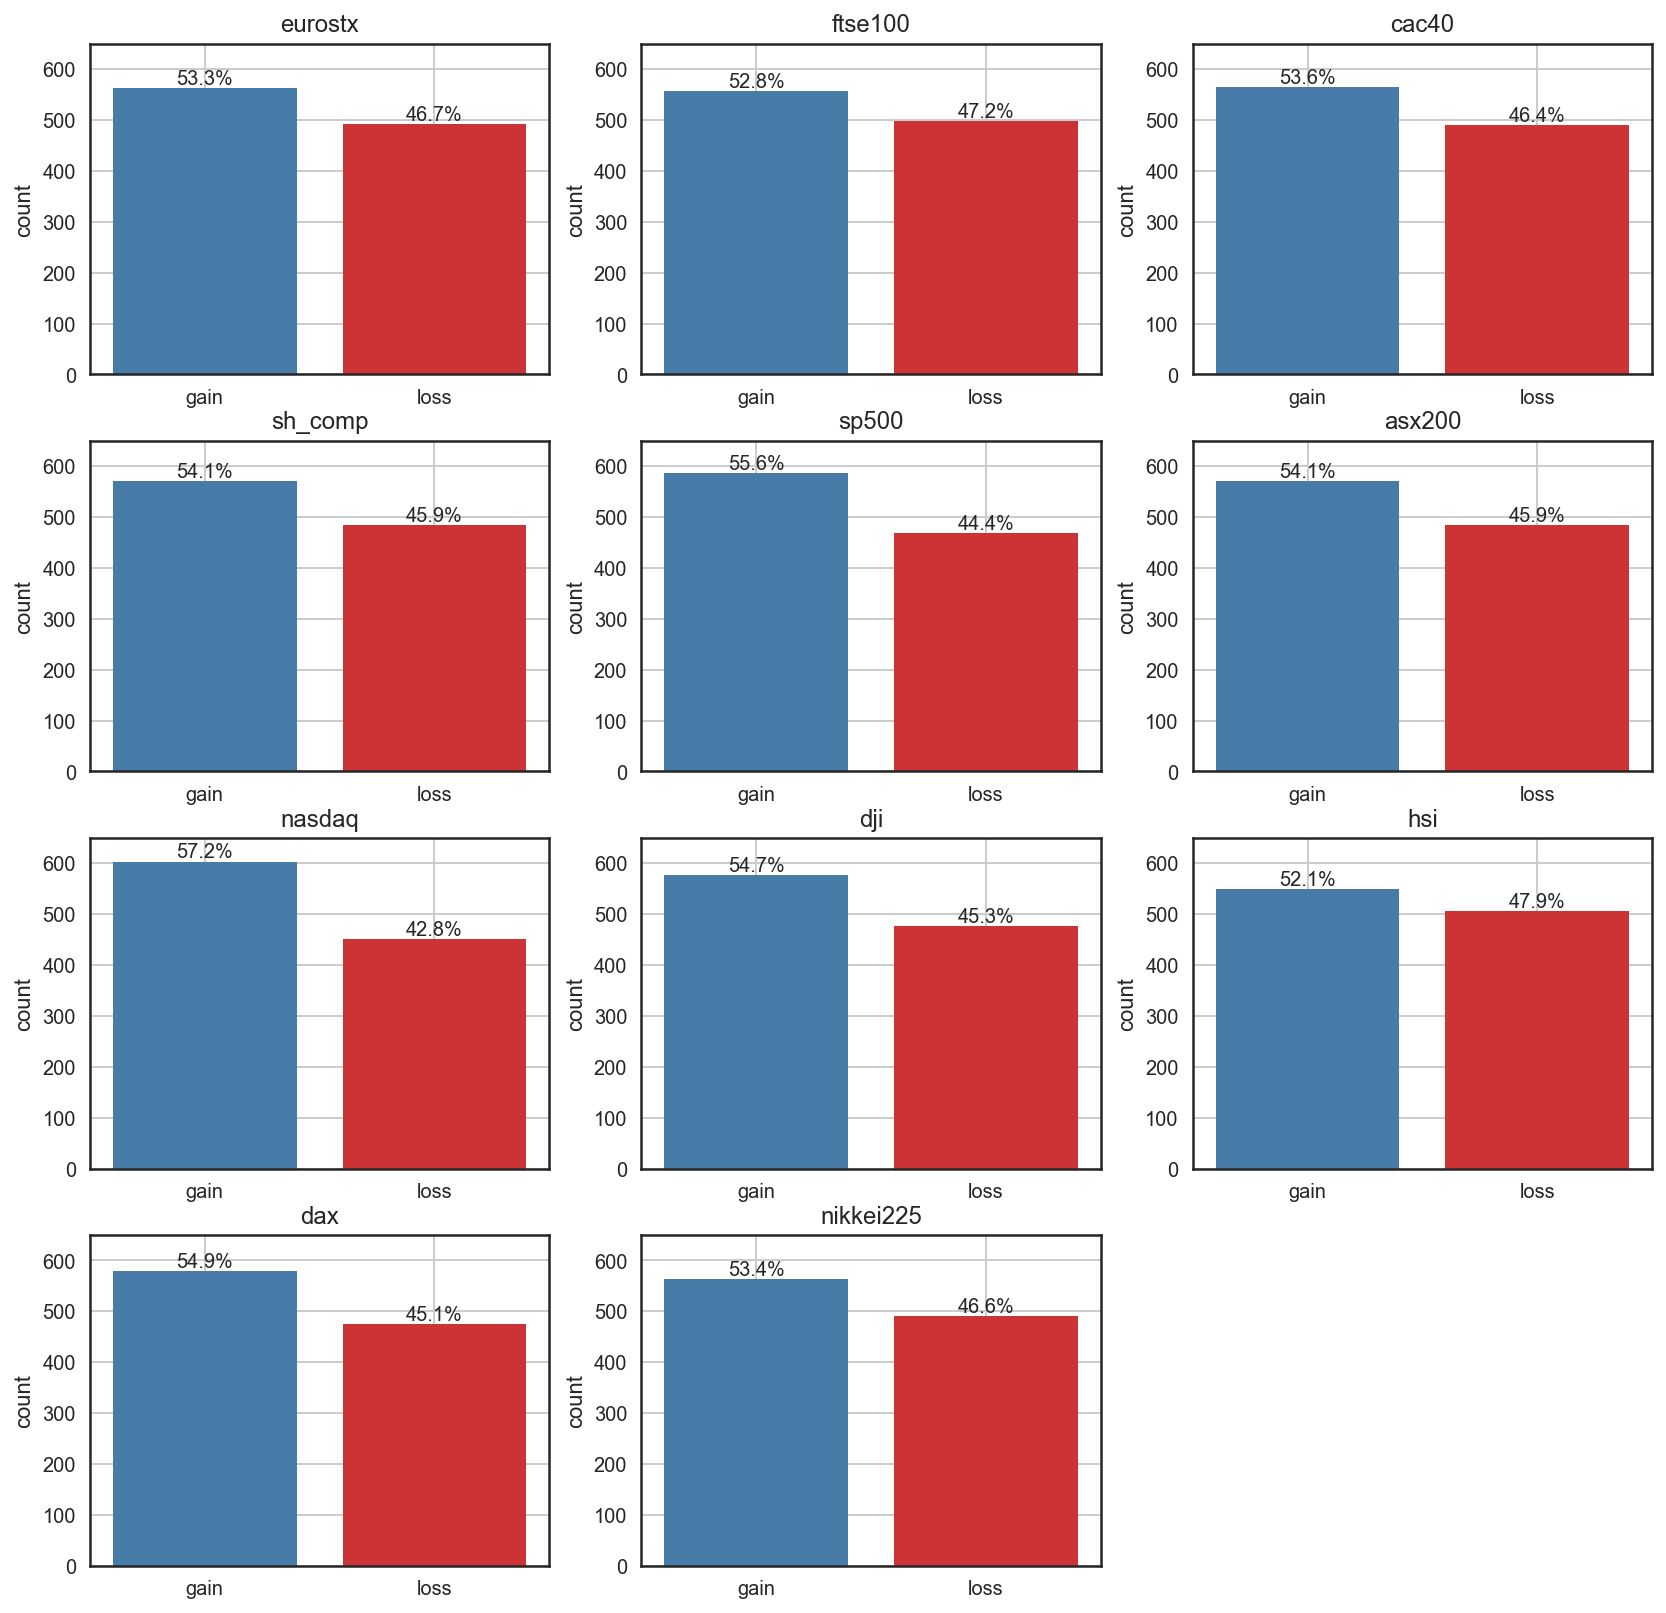

In [14]:
# frequency plot of daily gains and losses
columns = data_returns.columns.values
data_gainloss = pd.DataFrame(np.where(data_returns <= 0, 'loss', 'gain'), columns=columns)

n_rows=4
n_cols=3
colors=['#377eb8','#e41a1c']

fig=plt.figure(figsize=(14,14))

for i, column in enumerate(data_gainloss.columns):
    ax=fig.add_subplot(n_rows,n_cols,i+1)
    sns.countplot(x=column, data=data_gainloss, order=['gain', 'loss'], palette=colors);
    ax.set_title(column)
    ax.xaxis.label.set_visible(False)
    ax.set_ylim([0,650])
    ax.grid()
    
    # annotate bars
    ncount = len(data_gainloss)
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom')
        
plt.show()

Although it is highly unlikely, the daily return for an index can be 0. We consider a daily return of 0 to be a loss as most investors will seek to make a gain rather than staying constant or losing.

Analysis:

- all 11 indexes had more positive return days than negative ones in the past five years
- the index with the highest proportion of gains is the Nasdaq with 57.2%
- the index with the lowest proportion of gains is the HSI with 52.1%
- the data sets are relatively balanced, i.e. there is no overwhelming bias towards on outcome

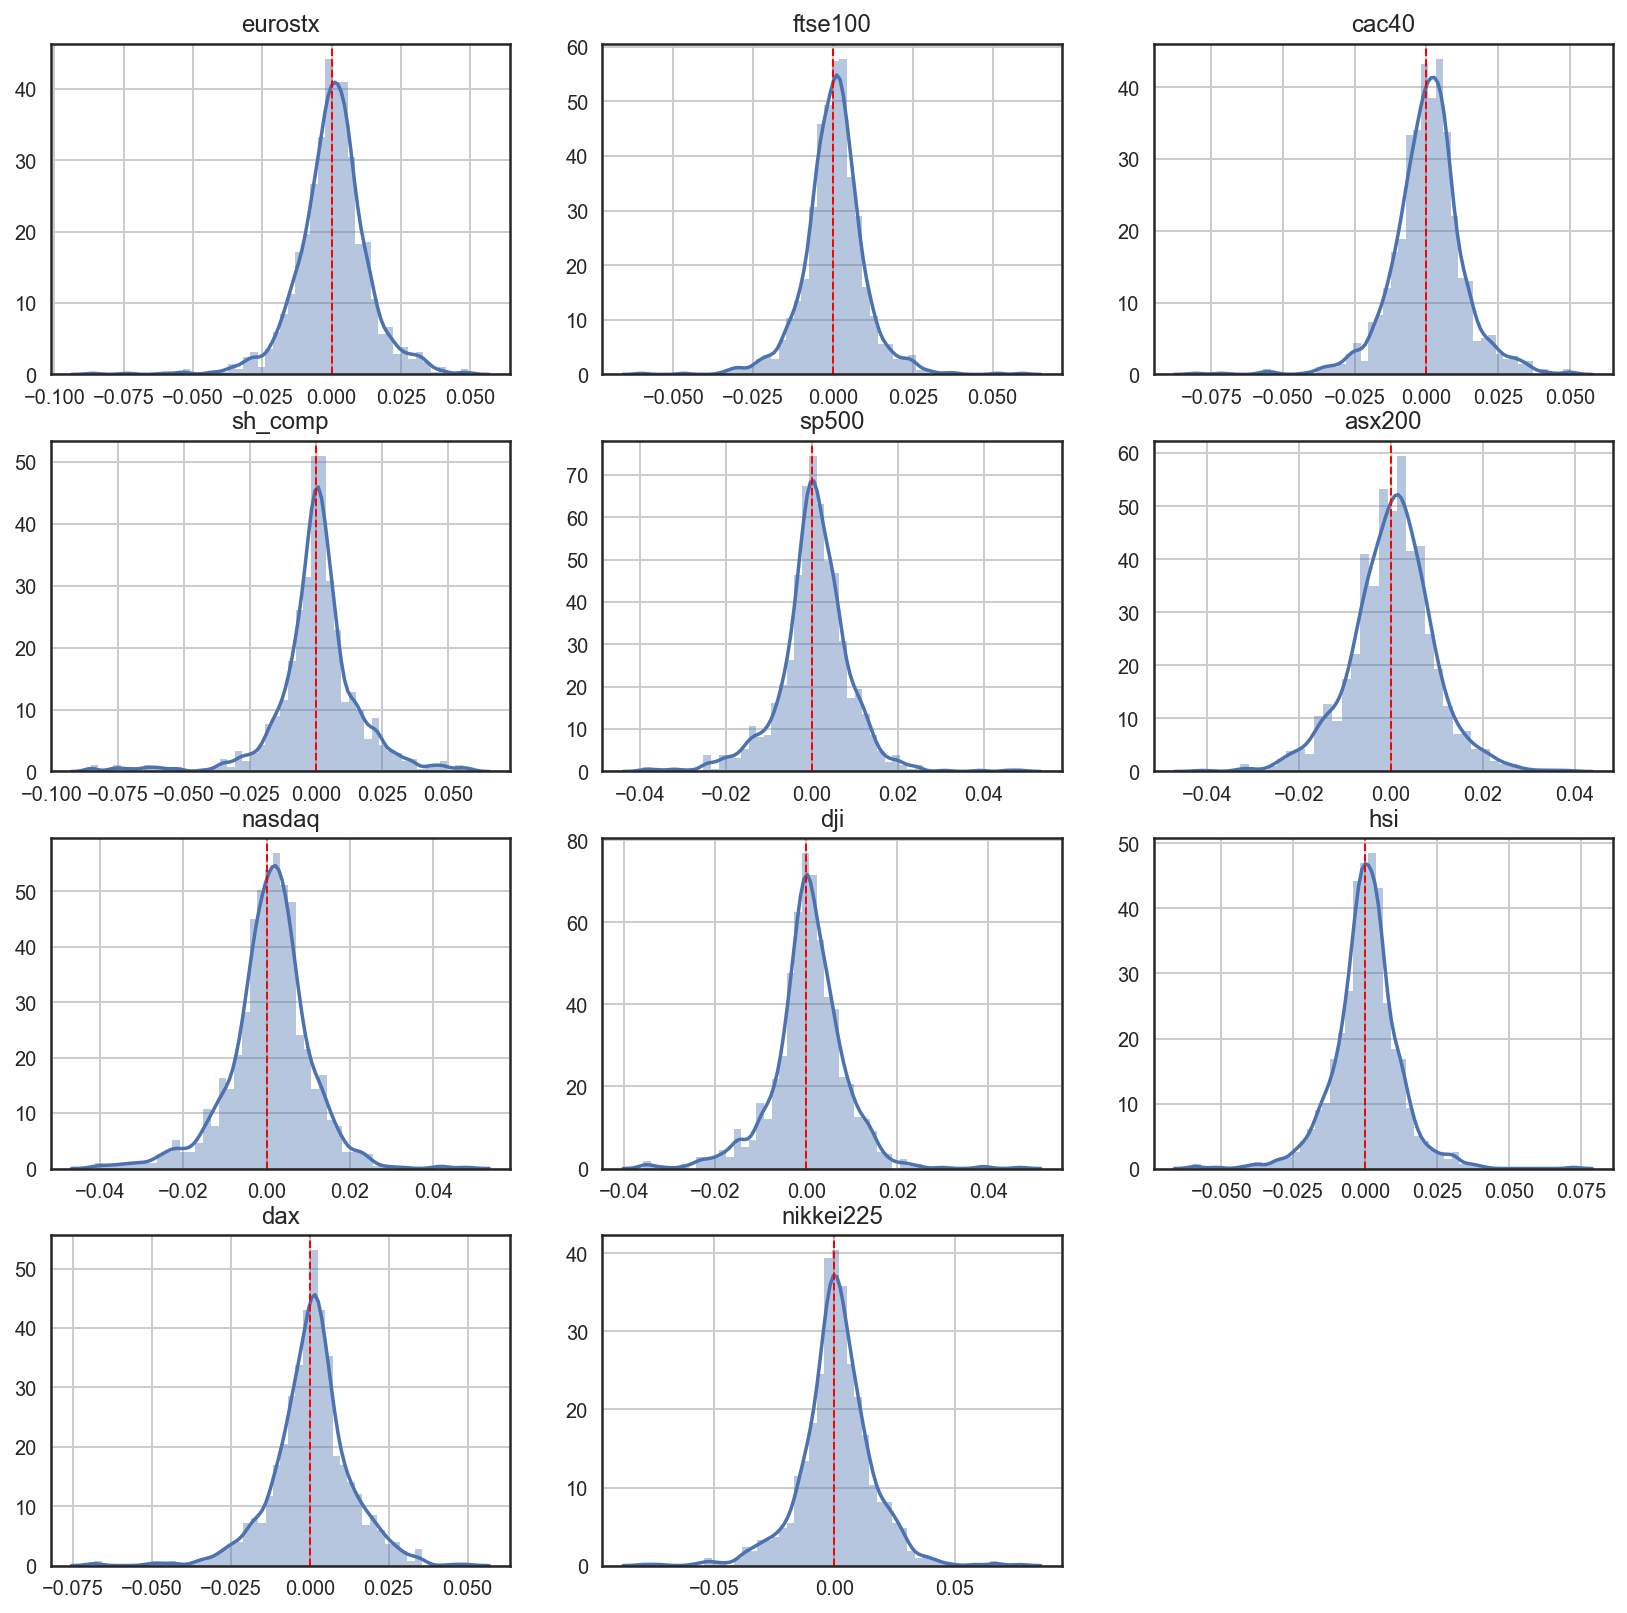

In [15]:
# distributions of returns

n_rows=4
n_cols=3

fig=plt.figure(figsize=(14,14))

for i, column in enumerate(data_returns.columns):
    x = data_returns[column]
    ax=fig.add_subplot(n_rows,n_cols,i+1)
    sns.distplot(x);
    plt.axvline(0, color='r', linestyle='dashed', linewidth=1)
    ax.set_title(column)
    ax.xaxis.label.set_visible(False)
    ax.grid()
    
plt.show()

Analysis:

- as revealed by the previous frequency plots, the modes for all the distributions lie slightly to the right or very slightly to the right of 0 meaning that, on average, the indexes have a positive daily return
- all the distributions have thin tails and most of the density is concentrated between -0.02 and 0.02

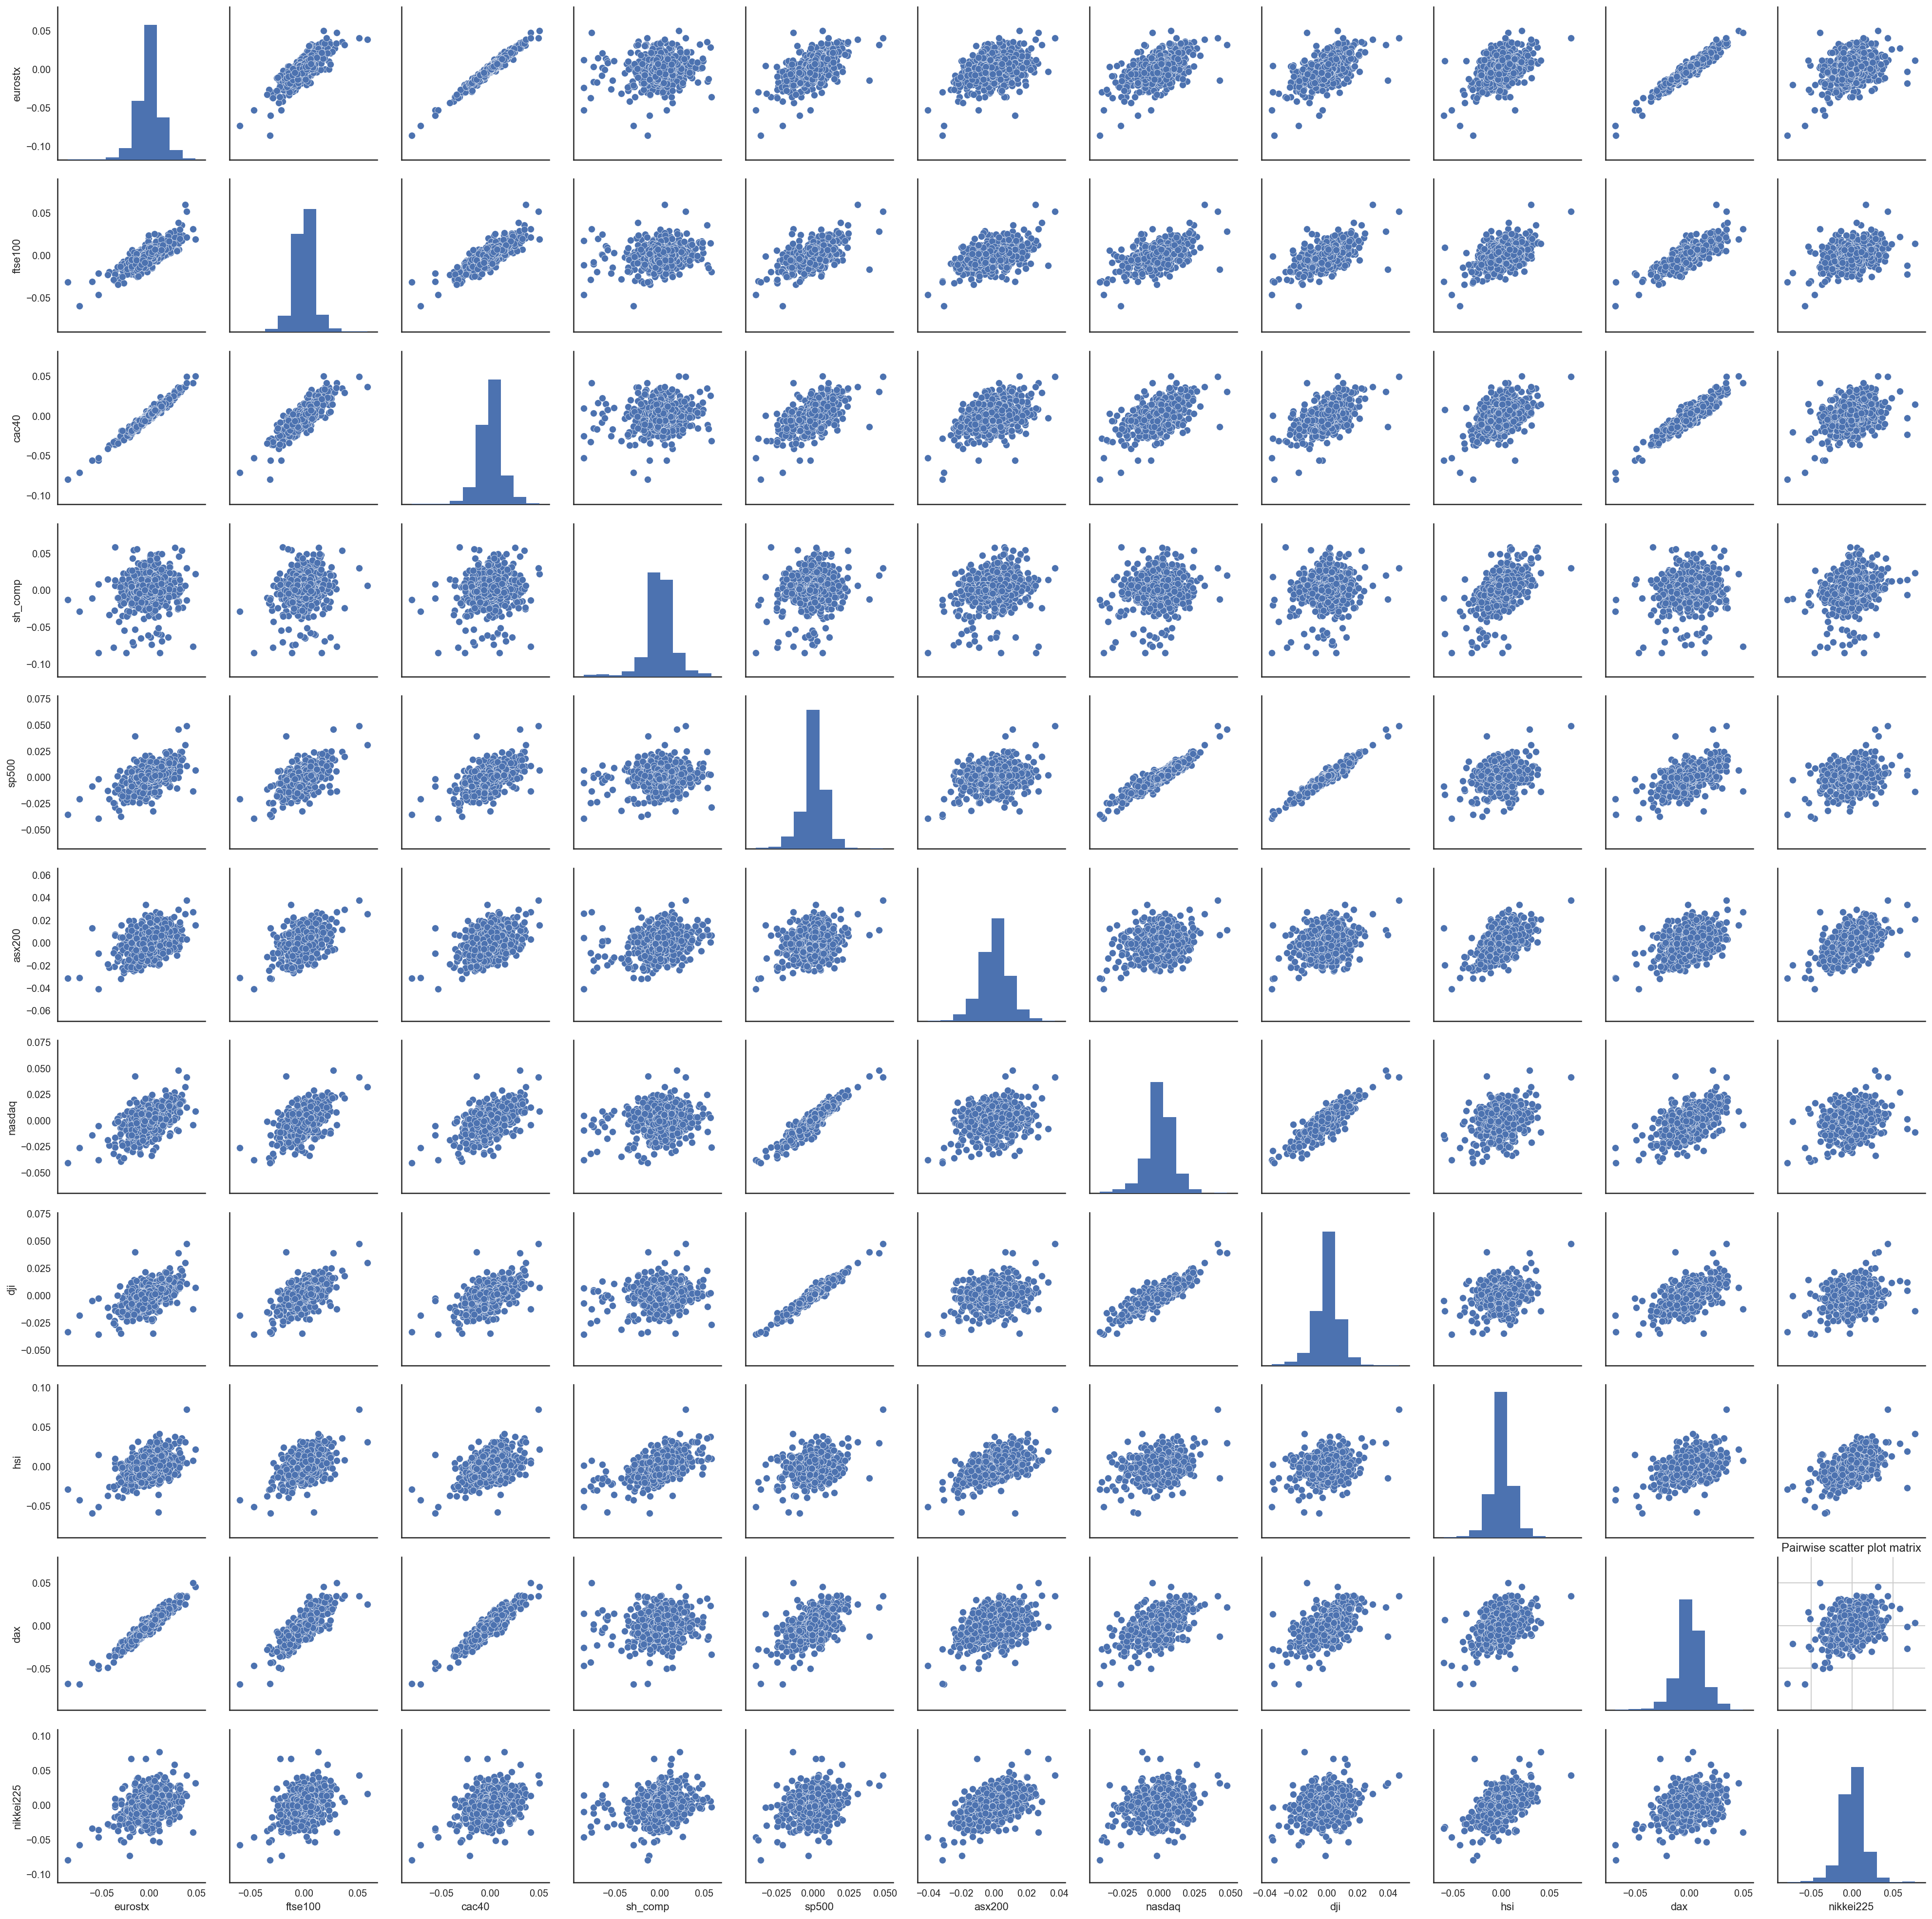

In [16]:
# scatter plots for all indexes pairs

sns.pairplot(data_returns);
plt.grid();
plt.title('Pairwise scatter plot matrix');

Analysis:

- all index pairs are at least slightly positively correlated and at best strongly positively correlated
- no index pairs shows signs of even weak negative correlation

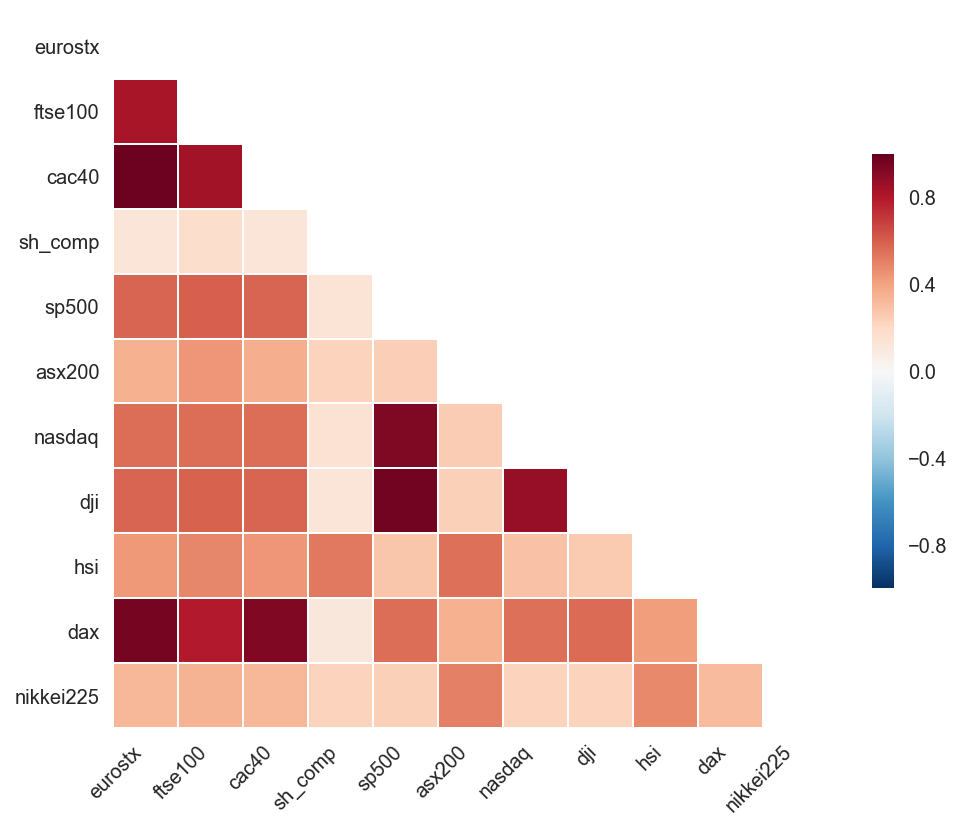

In [17]:
# correlation heatmap for entire period
mask = np.zeros_like(data_returns.corr(method='pearson'), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig=plt.figure(figsize=(8,8))
g = sns.heatmap(data_returns.corr(method='pearson'), center=0, square=True,
                mask=mask, cbar_kws={"shrink": .5}, linewidths=.5);
plt.xticks(rotation=45, ha='right');

Analysis:

- as recognized in the previous pairwise scatter plot matrix, no two indexes are negatively correlated over the entire five year period
- eurostx, ftse100, and cac40 form a cluster in the upper left corner

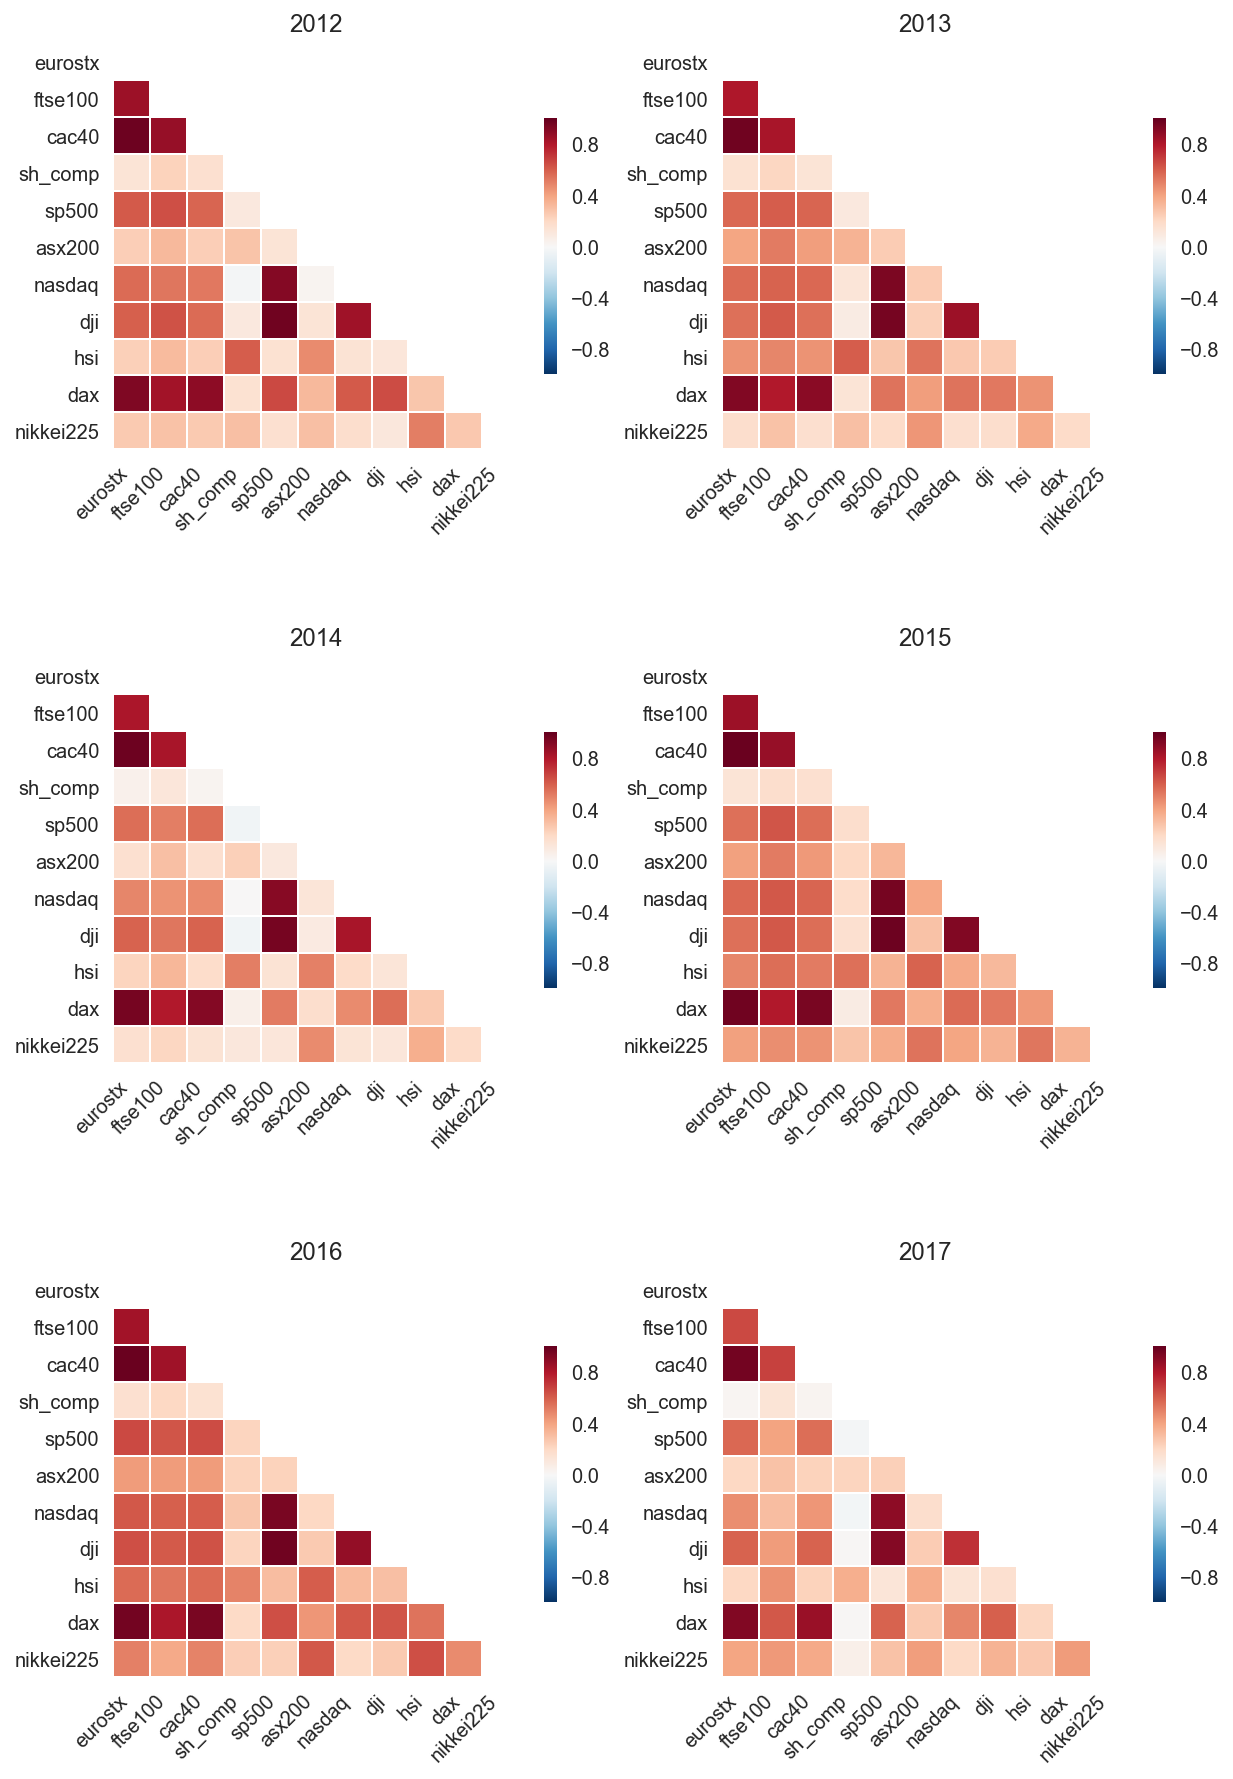

In [18]:
# correlation heatmaps for each year

n_rows=3
n_cols=2

fig=plt.figure(figsize=(10,16))

for i, year in enumerate(data_returns.index.year.unique()):
    temp = data_returns[data_returns.index.year == year]
    ax=fig.add_subplot(n_rows,n_cols,i+1)
    
    g = sns.heatmap(temp.corr(method='pearson'), center=0, square=True,
                    mask=mask, cbar_kws={"shrink": .5}, linewidths=.5)
    plt.title(year)
    plt.xticks(rotation=45, ha='right');

Analysis:

- at first glance it's difficult to see a pattern or a movement in the pattern
- the various various patterns throughout in the heatmap appear to remain constant over time but their intensity changes
- notably the triangle at the top, the 1 by 3 area one square above the bottom left, the vertical line from sh_comp on the x-axis

Mini conclusion:

- all indexes have increased from 2012 to 2017 speaking for the world ecnomies growth
- there is a bigger chance of randomly picking a day with positive returns than one with negative returns
- the distriubtions of returns for all stocks have high peaks    
    
- the markets appear to behave in a very similar way
- the structure of the market likely hasn't changed (or fundamentals) judging from the similar looking correlation plot progression
- the economies of developed countries have generally done good over the past five years (although cautious, high-level statement)

#### 3. Feature engineering

$$return_t= \frac{adjClose_t - adjClose_{t-1}}{adjClose_{t-1}}$$

$$movingAverage_{50}= \frac{return{t} + return{t-1} + ... + return{t-50}}{50}$$

$$return_{\delta}= \frac{adjClose_t - adjClose_{t-\delta}}{adjClose_{t-\delta}}$$

In [19]:
# save column names that will used in the loop
columns = data.columns.values

In [20]:
# helper functions for feature engineering
def lagged_return(data, columns, n=2):
    for column in columns:
        for i in range(n):
            name = column + '_lag_' + str(i+1)
            #new = pd.DataFrame(data[column][i+1:])
            new = pd.DataFrame(data[column].shift(i+1))
            new.columns = [name]
            data = pd.merge(data, new, how='inner', left_index=True, right_index=True)
    return data.dropna()


def moving_average(data, columns, window=50):
    for column in columns:
        name = column + '_' + str(window) + '_dayMA'
        temp = data[column]
        ma = pd.DataFrame(pd.rolling_mean(temp, window))
        ma.columns = [name]
        data = pd.merge(data, ma, how='inner', left_index=True, right_index=True)
    return data.dropna()

In [21]:
temp_final_data = lagged_return(data_returns, columns)
temp_final_data = moving_average(temp_final_data, columns)

/Users/Steven/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()


In [22]:
# multiple day returns for 3 and 5 days
data_multilple_day_return3 = data.pct_change(periods=3).dropna()
data_multilple_day_return5 = data.pct_change(periods=5).dropna()

# new column names for this data
columns_3 = [name + '_3dayreturns' for name in data_multilple_day_return3.columns.values]
columns_5 = [name + '_5dayreturns' for name in data_multilple_day_return5.columns.values]

data_multilple_day_return3.columns = columns_3
data_multilple_day_return5.columns = columns_5

# merge with final_data
final_data = pd.merge(temp_final_data, data_multilple_day_return3, how='inner', left_index=True, right_index=True)
final_data = pd.merge(final_data, data_multilple_day_return5, how='inner', left_index=True, right_index=True)

In [23]:
# create outcome variable
outcome = final_data['sp500']
outcome_var = np.where(outcome <= 0, 0, 1)

final_data['sp500'] = outcome_var
final_data = final_data.rename(columns={'sp500': 'sp500_outcome'})

In [24]:
# rearrange order of columns
order = [i for i in final_data.columns.values]
order.pop(4)
order.append('sp500_outcome')
order

final_data = final_data[order]
final_data.head()

eurostx   ftse100     cac40   sh_comp    asx200    nasdaq  \
Date                                                                     
2012-11-26  0.009065  0.006031  0.006781 -0.006334  0.012519  0.017164   
2012-11-27  0.000366  0.002245  0.000340 -0.013031  0.007369 -0.003020   
2012-11-28  0.001333  0.000616  0.003729 -0.008864 -0.002132  0.008083   
2012-11-29  0.013684  0.011549  0.015274 -0.005082  0.006836  0.006769   
2012-11-30 -0.002494 -0.000593 -0.003250  0.008470  0.006320 -0.000594   

                 dji       hsi       dax  nikkei225      ...        \
Date                                                     ...         
2012-11-26  0.010164  0.015678  0.014937   0.018045      ...         
2012-11-27 -0.006882 -0.000813  0.005527   0.003660      ...         
2012-11-28  0.008307 -0.006182  0.001511  -0.012199      ...         
2012-11-29  0.002827  0.009854  0.007837   0.009941      ...         
2012-11-30  0.000289  0.004904  0.000613   0.004801      ...         

            cac40_5dayreturns  sh_comp_5dayreturns  sp500_5dayreturns  \
Date                                                                    
2012-11-26           0.035046            -0.006319           0.039133   
2012-11-27           0.048065            -0.011689           0.028723   
2012-11-28           0.021982            -0.021547           0.016613   
2012-11-29           0.030854            -0.022614           0.020276   
2012-11-30           0.022983            -0.024725           0.018080   

            asx200_5dayreturns  nasdaq_5dayreturns  dji_5dayreturns  \
Date                                                                  
2012-11-26            0.017245            0.049293         0.033884   
2012-11-27            0.027670            0.040187         0.023023   
2012-11-28            0.019696            0.025963         0.014782   
2012-11-29            0.020977            0.032691         0.018244   
2012-11-30            0.031239            0.028597         0.014699   

            hsi_5dayreturns  dax_5dayreturns  nikkei225_5dayreturns  \
Date                                                                  
2012-11-26         0.035666         0.035297               0.063334   
2012-11-27         0.032375         0.054931               0.044230   
2012-11-28         0.021020         0.030822               0.016950   
2012-11-29         0.032721         0.031782               0.028246   
2012-11-30         0.023510         0.030731               0.024233   

            sp500_outcome  
Date                       
2012-11-26              1  
2012-11-27              0  
2012-11-28              1  
2012-11-29              1  
2012-11-30              1  

[5 rows x 66 columns]

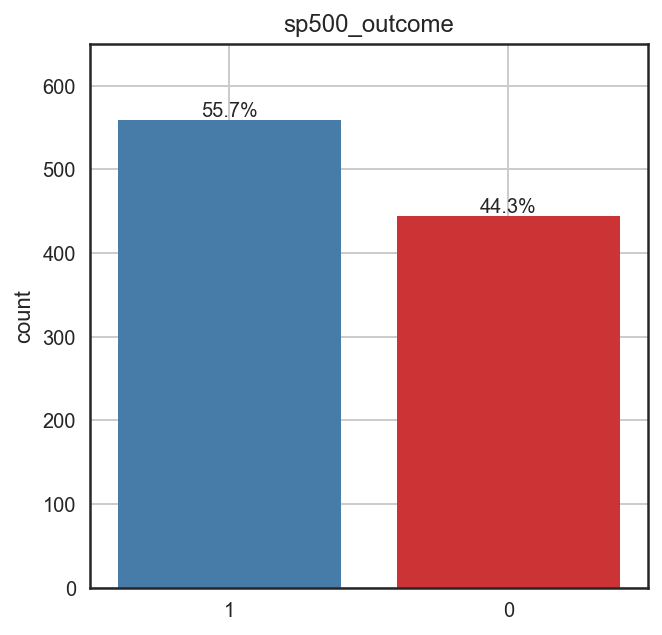

In [25]:
# plot frequency of outcome variable

fig=plt.figure(figsize=(5,5))

ax=fig.add_subplot(1,1,1)
sns.countplot(x='sp500_outcome', data=final_data, order=[1, 0], palette=colors);
ax.set_title('sp500_outcome')
ax.xaxis.label.set_visible(False)
ax.set_ylim([0,650])
ax.grid()
# annotate bars
ncount = len(final_data)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom')

Analysis:

- ratio slighlty different than in frequency plot above because some rows were eliminated in the feature engineering process

In [26]:
# number of features

print('Total features created: {}'.format(final_data.shape[1]))

Total features created: 66


In [27]:
# column names

for i, column in enumerate(final_data.columns):
    print('column {} name: {}'.format(str(i+1), column))

column 1 name: eurostx
column 2 name: ftse100
column 3 name: cac40
column 4 name: sh_comp
column 5 name: asx200
column 6 name: nasdaq
column 7 name: dji
column 8 name: hsi
column 9 name: dax
column 10 name: nikkei225
column 11 name: eurostx_lag_1
column 12 name: eurostx_lag_2
column 13 name: ftse100_lag_1
column 14 name: ftse100_lag_2
column 15 name: cac40_lag_1
column 16 name: cac40_lag_2
column 17 name: sh_comp_lag_1
column 18 name: sh_comp_lag_2
column 19 name: sp500_lag_1
column 20 name: sp500_lag_2
column 21 name: asx200_lag_1
column 22 name: asx200_lag_2
column 23 name: nasdaq_lag_1
column 24 name: nasdaq_lag_2
column 25 name: dji_lag_1
column 26 name: dji_lag_2
column 27 name: hsi_lag_1
column 28 name: hsi_lag_2
column 29 name: dax_lag_1
column 30 name: dax_lag_2
column 31 name: nikkei225_lag_1
column 32 name: nikkei225_lag_2
column 33 name: eurostx_50_dayMA
column 34 name: ftse100_50_dayMA
column 35 name: cac40_50_dayMA
column 36 name: sh_comp_50_dayMA
column 37 name: sp500_50_

In [28]:
print('The engineered data set has dimensions: {}'.format(final_data.shape))   # includes outcome variable

The engineered data set has dimensions: (1003, 66)


#### 4. Feature selection

The project uses a filter method to standardize the starting conditions for both machine learning algorithms.

In [29]:
# separate features from outcome variable 
X = final_data.iloc[:, :-1]
y = final_data.iloc[:, -1]

/Users/Steven/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


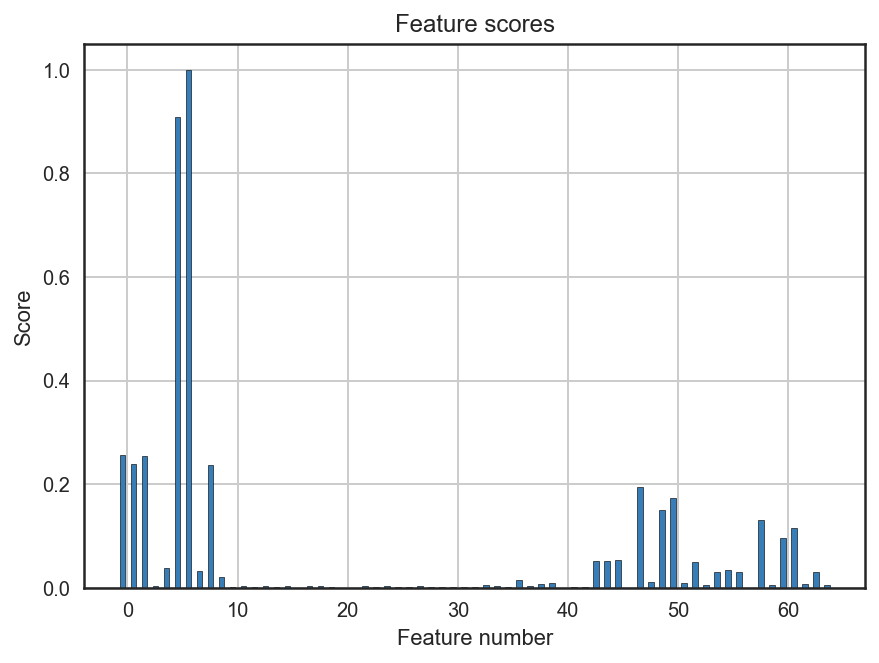

In [30]:
# apply scoring function and create two data sets with 10% and 25% highest scoring features

# colors
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
# X labels
X_indices = np.arange(X.shape[-1])

plt.figure(figsize=(7,5))

selector_f_classif = SelectPercentile(f_classif, percentile=10)
selector_f_classif.fit(X, y)
X_10_perc = selector_f_classif.fit_transform(X, y)
cols_10 = selector_f_classif.get_support()   # use this to find which features were used
cols_10_names = X.iloc[:, cols_10.tolist()].columns # get names of features used 

selector_f_classif = SelectPercentile(f_classif, percentile=25)
selector_f_classif.fit(X, y)
X_25_perc = selector_f_classif.fit_transform(X, y)
cols_25 = selector_f_classif.get_support()   # use this to find which features were used
cols_25_names = X.iloc[:, cols_25.tolist()].columns # get names of features used 

scores_f_classif = selector_f_classif.scores_
scores_f_classif /= scores_f_classif.max()
plt.bar(X_indices - .45, scores_f_classif, width=.5, color=colors[1],
        edgecolor='black')

# plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.ylabel('Score')
plt.title('Feature scores')
plt.axis('tight')
plt.grid()
plt.legend(loc='upper right');

In [31]:
# columns in top 10% data set
for i, column in enumerate(cols_10_names):
    print('column {} name: {}'.format(str(i+1), column))

column 1 name: eurostx
column 2 name: ftse100
column 3 name: cac40
column 4 name: nasdaq
column 5 name: dji
column 6 name: dax
column 7 name: sp500_3dayreturns


In [32]:
# columns in top 25% data set
for i, column in enumerate(cols_25_names):
    print('column {} name: {}'.format(str(i+1), column))

column 1 name: eurostx
column 2 name: ftse100
column 3 name: cac40
column 4 name: nasdaq
column 5 name: dji
column 6 name: dax
column 7 name: eurostx_3dayreturns
column 8 name: ftse100_3dayreturns
column 9 name: cac40_3dayreturns
column 10 name: sp500_3dayreturns
column 11 name: nasdaq_3dayreturns
column 12 name: dji_3dayreturns
column 13 name: dax_3dayreturns
column 14 name: sp500_5dayreturns
column 15 name: nasdaq_5dayreturns
column 16 name: dji_5dayreturns


#### 5. Data preparation before modeling

In [33]:
# data preparation

remove_days = 129

X_train_10 = X_10_perc[:-remove_days, :]   # from row 0 to (end - 120)
X_test_10 = X_10_perc[(len(X) - remove_days):, :]   # from row (end - 120) to end

X_train_25 = X_25_perc[:-remove_days, :]   # from row 0 to (end - 120)
X_test_25 = X_25_perc[(len(X) - remove_days):, :]   # from row (end - 120) to end

y_train = y[:-remove_days]
y_test = y[(len(X) - remove_days):]

# for NN

# create validation data set (for neural nets)
val_split = round(len(X_train_10) * 0.8)

X_train_10_nn = X_train_10[:val_split, :]
X_validation_10_nn = X_train_10[val_split:, :]

X_train_25_nn = X_train_25[:val_split, :]
X_validation_25_nn = X_train_25[val_split:, :]

y_train_nn = y_train[:val_split]
y_validation_nn = y_train[val_split:]

# convert class vector to binary class matrix
nr_classes = 2

y_train_onehot = np_utils.to_categorical(y_train_nn, nr_classes)
y_validation_onehot = np_utils.to_categorical(y_validation_nn, nr_classes)
y_test_onehot = np_utils.to_categorical(y_test, nr_classes)

In [34]:
# produce 100 test data sets to make 100 30-day-ahead predictions

remove_days = 129

all_X_test_data_10perc = {}
all_X_test_data_25perc = {}
all_y_test_data = {}
all_y_test_onehot = {}


for count, i in enumerate(range(len(X_10_perc)-remove_days, len(X_10_perc)-30+1)):
    
    name_X = 'X_test_' + str(1+count)
    name_y = 'y_test_' + str(1+count)
    all_X_test_data_10perc[name_X] = X_10_perc[i:i+30, :]  
    all_X_test_data_25perc[name_X] = X_25_perc[i:i+30, :]  
    all_y_test_data[name_y] = y[i:i+30]
    all_y_test_onehot[name_y] = np_utils.to_categorical(y[i:i+30], nr_classes)

In [35]:
keys_X = ['X_test_' + str(i+1) for i in range(100)] 
keys_y = ['y_test_' + str(i+1) for i in range(100)] 

#### 6. Prediction

#### 6.1. Support vector machines

As the range of the features is relatively uniform between (-0.05, 0.05) the data are not normalized.

##### Experiments:
1. Tune hyper parameter C on top 10% data set   
2. Tune hyper parameter C on top 10% data set   

#### 6.1.1. SVM first experiment

In [36]:
# 10-fold cross validation with SVM
tscv = TimeSeriesSplit(n_splits=10)

# hyperparameter
c_10 = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]
#c = [0.01, 0.1, 1, 10, 100, 1000, 10000]

all_scores_svm_10 = []
for c_value in c_10:
    # initiate model
    svc_10p = SVC(kernel='linear', C=c_value)
    # create folds
    scores = []
    for train_index, test_index in tscv.split(X_train_10):
        # print(train_index, test_index)
        if str(type(X_train_10)) == "<class 'pandas.core.frame.DataFrame'>":
            X_train_fold, X_test_fold = X_train_10.iloc[train_index,], X_train_10.iloc[test_index,]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        else:
            X_train_fold, X_test_fold = X_train_10[train_index,], X_train_10[test_index,]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        # print(len(X_train_fold))
        svc_10p.fit(X_train_fold, y_train_fold)   # train
        #print(svc.predict(X_test_fold))
        scores.append(svc_10p.score(X_test_fold, y_test_fold))   # evaluate accuracy
    all_scores_svm_10.append(np.array(scores).mean())
    
print('Best result is {} at c={}.'.format(max(all_scores_svm_10), c_10[all_scores_svm_10.index(max(all_scores_svm_10))]))

Best result is 0.9202531645569619 at c=10000.


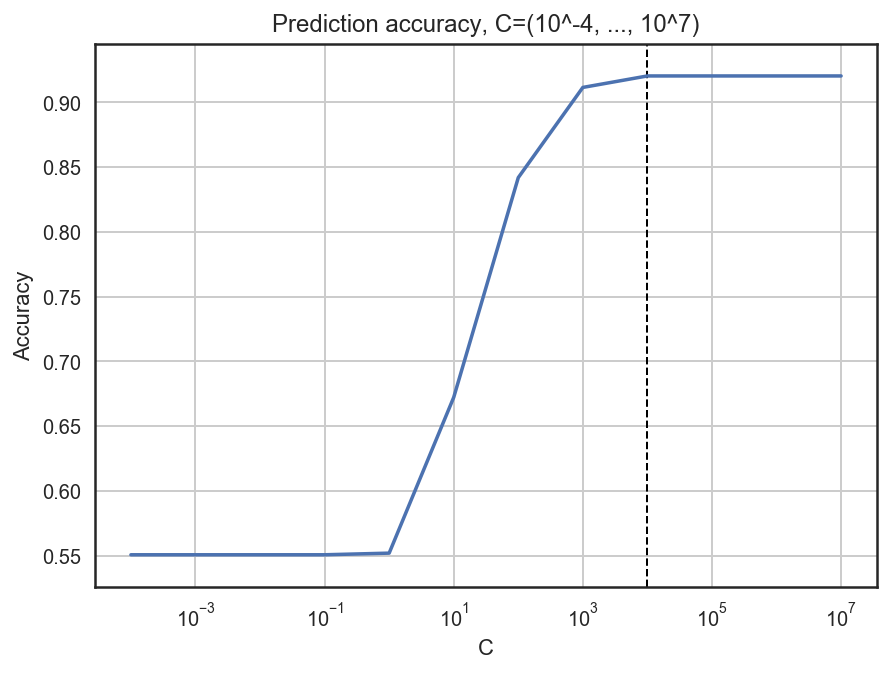

In [37]:
plt.figure(figsize=(7,5))

plt.plot(c_10, all_scores_svm_10)
plt.vlines(c_10[all_scores_svm_10.index(max(all_scores_svm_10))],
           ymin=min(all_scores_svm_10)-0.025, ymax=max(all_scores_svm_10)+0.025, linestyles='dashed', linewidth=1)

plt.ylim(ymin=min(all_scores_svm_10)-0.025, ymax=max(all_scores_svm_10)+0.025)
plt.xscale('log')
plt.grid()
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Prediction accuracy, C=(10^-4, ..., 10^7)');

In [38]:
%%time
# attempt at fine-tuning results for SVM by searching interval 800,000 to 2,000,000

# hyperparameter
c_refined_10 = [int(i) for i in np.linspace(3000, 15000, num=30)]

all_scores_svm_10_refined = []
for c_value in c_refined_10:
    # initiate model
    svc_10p_refined = SVC(kernel='linear', C=c_value)
    # create folds
    scores = []
    for train_index, test_index in tscv.split(X_train_10):
        # print(train_index, test_index)
        if str(type(X_train_10)) == "<class 'pandas.core.frame.DataFrame'>":
            X_train_fold, X_test_fold = X_train_10.iloc[train_index,], X_train_10.iloc[test_index,]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        else:
            X_train_fold, X_test_fold = X_train_10[train_index,], X_train_10[test_index,]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        # print(len(X_train_fold))
        svc_10p_refined.fit(X_train_fold, y_train_fold)   # train
        #print(svc.predict(X_test_fold))
        scores.append(svc_10p_refined.score(X_test_fold, y_test_fold))   # evaluate accuracy
    all_scores_svm_10_refined.append(np.array(scores).mean())
    
print('Best result is {} at c={}.'.format(max(all_scores_svm_10_refined), 
                                          c_refined_10[all_scores_svm_10_refined.index(max(all_scores_svm_10_refined))]))

Best result is 0.9215189873417721 at c=14586.
CPU times: user 1.24 s, sys: 5.51 ms, total: 1.24 s
Wall time: 1.25 s


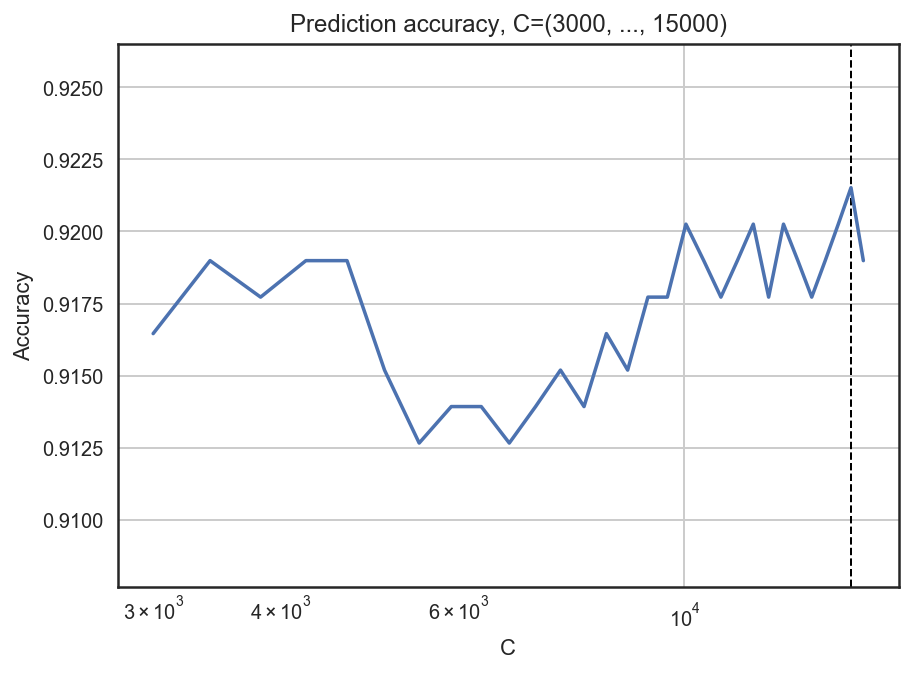

In [39]:
plt.figure(figsize=(7,5))

plt.plot(c_refined_10, all_scores_svm_10_refined)
plt.vlines(c_refined_10[all_scores_svm_10_refined.index(max(all_scores_svm_10_refined))],
           ymin=min(all_scores_svm_10_refined)-0.005, ymax=max(all_scores_svm_10_refined)+0.005, linestyles='dashed', linewidth=1)

plt.ylim(ymin=min(all_scores_svm_10_refined)-0.005, ymax=max(all_scores_svm_10_refined)+0.005)
plt.xscale('log')
plt.grid()
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Prediction accuracy, C=(3000, ..., 15000)');

The refined values of c provide a slight improvement in performance.

##### Prediction on test data

In [40]:
%%time
# prediction on test data

all_prediction_acc_10 = []
keys_both = zip(keys_X, keys_y)

c=14586
svc_10p_final = SVC(kernel='linear', C=c)

svc_10p_final.fit(X_train_10, y_train)
for item in keys_both:
    #print(item)
    prediction = svc_10p_final.predict(all_X_test_data_10perc[item[0]])
    accuracy = svc_10p_final.score(all_X_test_data_10perc[item[0]], all_y_test_data[item[1]])                                                                
    #print(prediction)
    all_prediction_acc_10.append(accuracy)

print('The average accuracy on the for 100 30-day-ahead predictions is {}.'.format(np.array(all_prediction_acc_10).mean()))

The average accuracy on the for 100 30-day-ahead predictions is 0.8893333333333334.
CPU times: user 135 ms, sys: 1.61 ms, total: 137 ms
Wall time: 137 ms


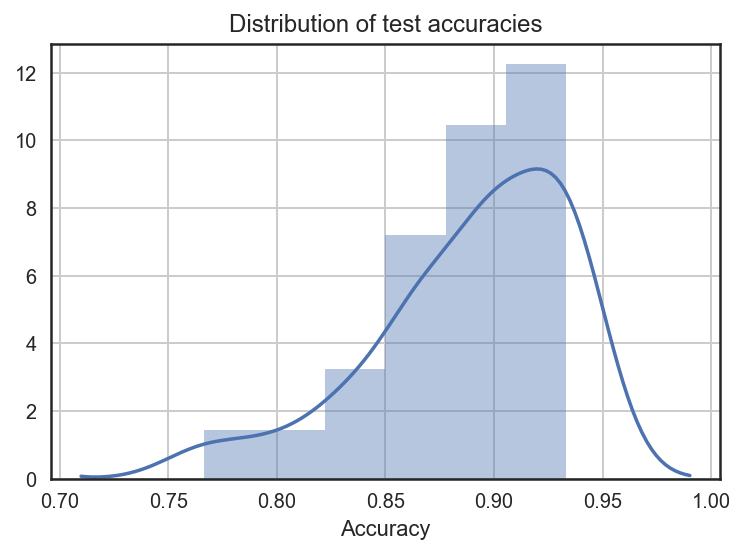

In [41]:
# distribution of test accuracies
x_svm_10 = all_prediction_acc_10
sns.distplot(x_svm_10, axlabel='Accuracy')

ax = plt.axes()
ax.set_title('Distribution of test accuracies')
ax.grid()

#### 6.1.2. SVM second experiment
The second experiment uses top 25% selected features.

In [42]:
%%time
# 10-fold cross validation with SVM

tscv = TimeSeriesSplit(n_splits=10)

# hyperparameter
c_25 = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]
#c_25 = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]

all_scores_svm_25 = []
for c_value in c_25:
    # initiate model
    svc_25p = SVC(kernel='linear', C=c_value)
    # create folds
    scores = []
    for train_index, test_index in tscv.split(X_train_25):
        # print(train_index, test_index)
        if str(type(X_train_25)) == "<class 'pandas.core.frame.DataFrame'>":
            X_train_fold, X_test_fold = X_train_25.iloc[train_index,], X_train_25.iloc[test_index,]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        else:
            X_train_fold, X_test_fold = X_train_25[train_index,], X_train_25[test_index,]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        # print(len(X_train_fold))
        svc_25p.fit(X_train_fold, y_train_fold)   # train
        #print(svc.predict(X_test_fold))
        scores.append(svc_25p.score(X_test_fold, y_test_fold))   # evaluate accuracy
    all_scores_svm_25.append(np.array(scores).mean())
    
print('Best result is {} at c={}.'.format(max(all_scores_svm_25), c_25[all_scores_svm_25.index(max(all_scores_svm_25))]))

Best result is 0.9329113924050633 at c=10000.
CPU times: user 2min 17s, sys: 217 ms, total: 2min 18s
Wall time: 2min 18s


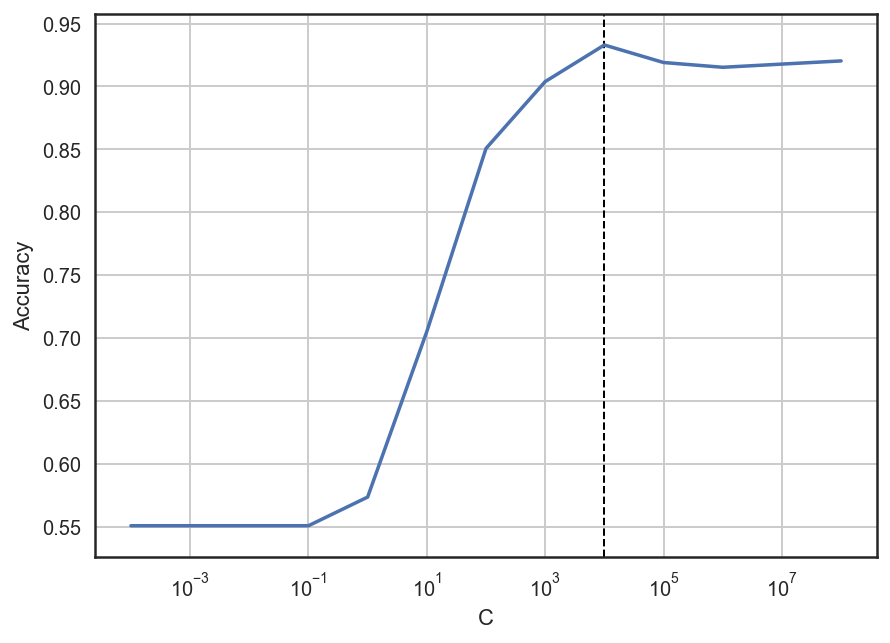

In [43]:
plt.figure(figsize=(7,5))

plt.plot(c_25, all_scores_svm_25)
plt.vlines(c_25[all_scores_svm_25.index(max(all_scores_svm_25))], ymin=min(all_scores_svm_25)-0.025, ymax=max(all_scores_svm_25)+0.025, linestyles='dashed', linewidth=1)

plt.ylim(ymin=min(all_scores_svm_25)-0.025, ymax=max(all_scores_svm_25)+0.025)
plt.xscale('log')
plt.grid()
plt.xlabel('C')
plt.ylabel('Accuracy')
#plt.title('Prediction accuracy, C=[0.0001, 10000000]');

In [44]:
%%time
# attempt at fine-tuning results for SVM by searching interval 500 to 15000

# hyperparameter
c_refined_25 = [int(i) for i in np.linspace(500, 15000, num=30)]

all_scores_svm_25_refined = []
for c_value in c_refined_25:
    # initiate model
    svc_25p_refined = SVC(kernel='linear', C=c_value)
    # create folds
    scores = []
    for train_index, test_index in tscv.split(X_train_25):
        # print(train_index, test_index)
        if str(type(X_train_25)) == "<class 'pandas.core.frame.DataFrame'>":
            X_train_fold, X_test_fold = X_train_25.iloc[train_index,], X_train_25.iloc[test_index,]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        else:
            X_train_fold, X_test_fold = X_train_25[train_index,], X_train_25[test_index,]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        # print(len(X_train_fold))
        svc_25p_refined.fit(X_train_fold, y_train_fold)   # train
        #print(svc.predict(X_test_fold))
        scores.append(svc_25p_refined.score(X_test_fold, y_test_fold))   # evaluate accuracy
    all_scores_svm_25_refined.append(np.array(scores).mean())
    
print('Best result is {} at c={}.'.format(max(all_scores_svm_25_refined), 
                                          c_refined_25[all_scores_svm_25_refined.index(max(all_scores_svm_25_refined))]))

Best result is 0.9341772151898734 at c=11000.
CPU times: user 2.25 s, sys: 11.7 ms, total: 2.26 s
Wall time: 2.29 s


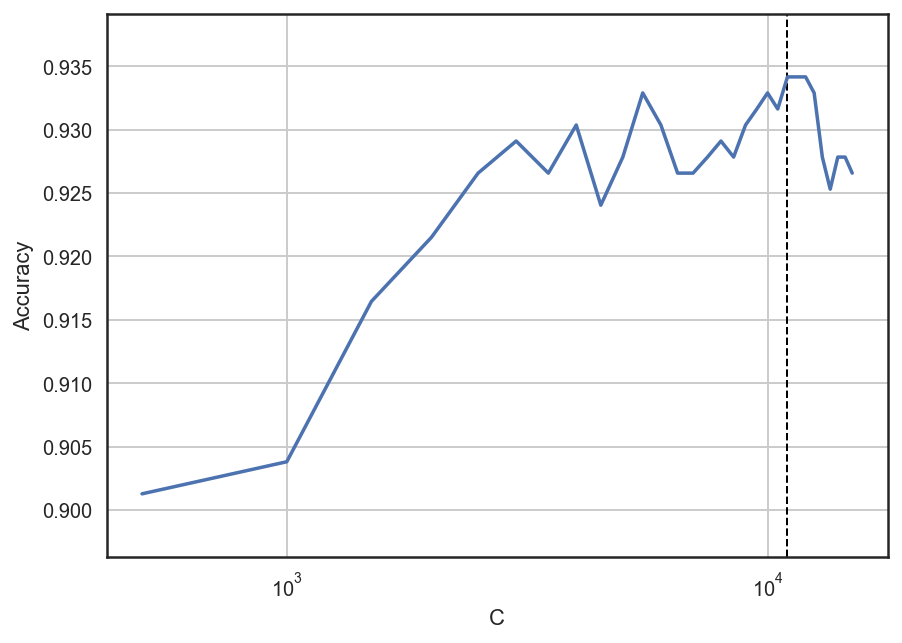

In [45]:
plt.figure(figsize=(7,5))

plt.plot(c_refined_25, all_scores_svm_25_refined)
plt.vlines(c_refined_25[all_scores_svm_25_refined.index(max(all_scores_svm_25_refined))],
           ymin=min(all_scores_svm_25_refined)-0.005, ymax=max(all_scores_svm_25_refined)+0.005, linestyles='dashed', linewidth=1)

plt.ylim(ymin=min(all_scores_svm_25_refined)-0.005, ymax=max(all_scores_svm_25_refined)+0.005)
plt.xscale('log')
plt.grid()
plt.xlabel('C')
plt.ylabel('Accuracy')

##### Prediction on test data

In [46]:
%%time
# prediction on test data

all_prediction_acc_25 = []
keys_both = zip(keys_X, keys_y)

c=11000
svc_25p_final = SVC(kernel='linear', C=c)

svc_25p_final.fit(X_train_25, y_train)
for item in keys_both:
    #print(item)
    prediction = svc_25p_final.predict(all_X_test_data_25perc[item[0]])
    accuracy = svc_25p_final.score(all_X_test_data_25perc[item[0]], all_y_test_data[item[1]])                                                                
    #print(prediction)
    all_prediction_acc_25.append(accuracy)

print('The average accuracy on the for 100 30-day-ahead predictions is {}.'.format(np.array(all_prediction_acc_25).mean()))

The average accuracy on the for 100 30-day-ahead predictions is 0.8963333333333336.
CPU times: user 98.4 ms, sys: 916 µs, total: 99.3 ms
Wall time: 99.1 ms


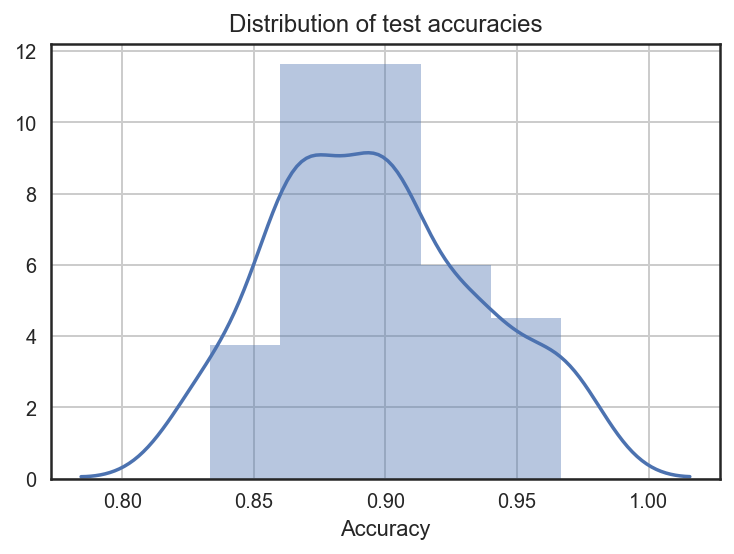

In [47]:
# distribution of test accuracies
x_svm_25 = all_prediction_acc_25
sns.distplot(x_svm_25, axlabel='Accuracy')

ax = plt.axes()
ax.set_title('Distribution of test accuracies')
plt.grid()

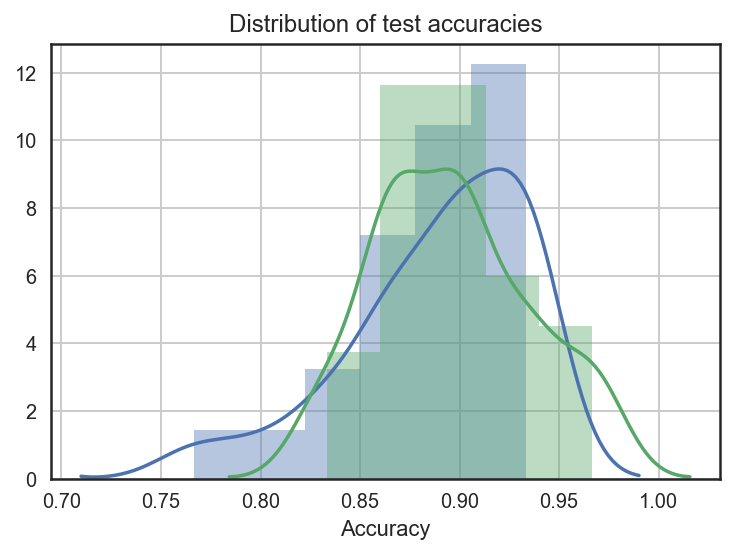

In [48]:
# comparison of both accuracy distributions

sns.distplot(x_svm_10, axlabel='Accuracy')
sns.distplot(x_svm_25, axlabel='Accuracy')

ax = plt.axes()
ax.set_title('Distribution of test accuracies')
plt.grid()

#### 6.2. Feed forward neural net

##### Experiments:
1 and 3: Tune number of nodes in hidden layer on 10% data set, nodes (16,32), batch size (128)    
2 and 4: Tune number of nodes in hidden layer on 25% data set, nodes (16,32), batch size (128)

#### 6.2.1. experiment
10% data, 16 nodes, 128 batch size

In [49]:
# create neural network
input_dims = X_train_10.shape[1]   # number of features that go into the model

model_10_16n = Sequential()
model_10_16n.add(Dense(16, input_shape=(input_dims, ), name='hidden', use_bias=True), )   # units is the number of units in the layer 
model_10_16n.add(Activation('relu'))
model_10_16n.add(Dense(2, name='output', use_bias=False))   # number of output classes
model_10_16n.add(Activation('softmax'))
#sgd = optimizers.SGD(lr=0.01, decay=1e-06, momentum=0.9, nesterov=True)
sgd = optimizers.SGD(lr=0.01, decay=1e-06)
model_10_16n.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [50]:
model_10_16n.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 16)                128       
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
output (Dense)               (None, 2)                 32        
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________


In [51]:
%%time
m_10_16n = model_10_16n.fit(X_train_10_nn, y_train_onehot, validation_data=(X_validation_10_nn, y_validation_onehot),
              batch_size=128, epochs=20000, shuffle=True, verbose=0)

CPU times: user 4min 3s, sys: 1min 21s, total: 5min 25s
Wall time: 3min 33s


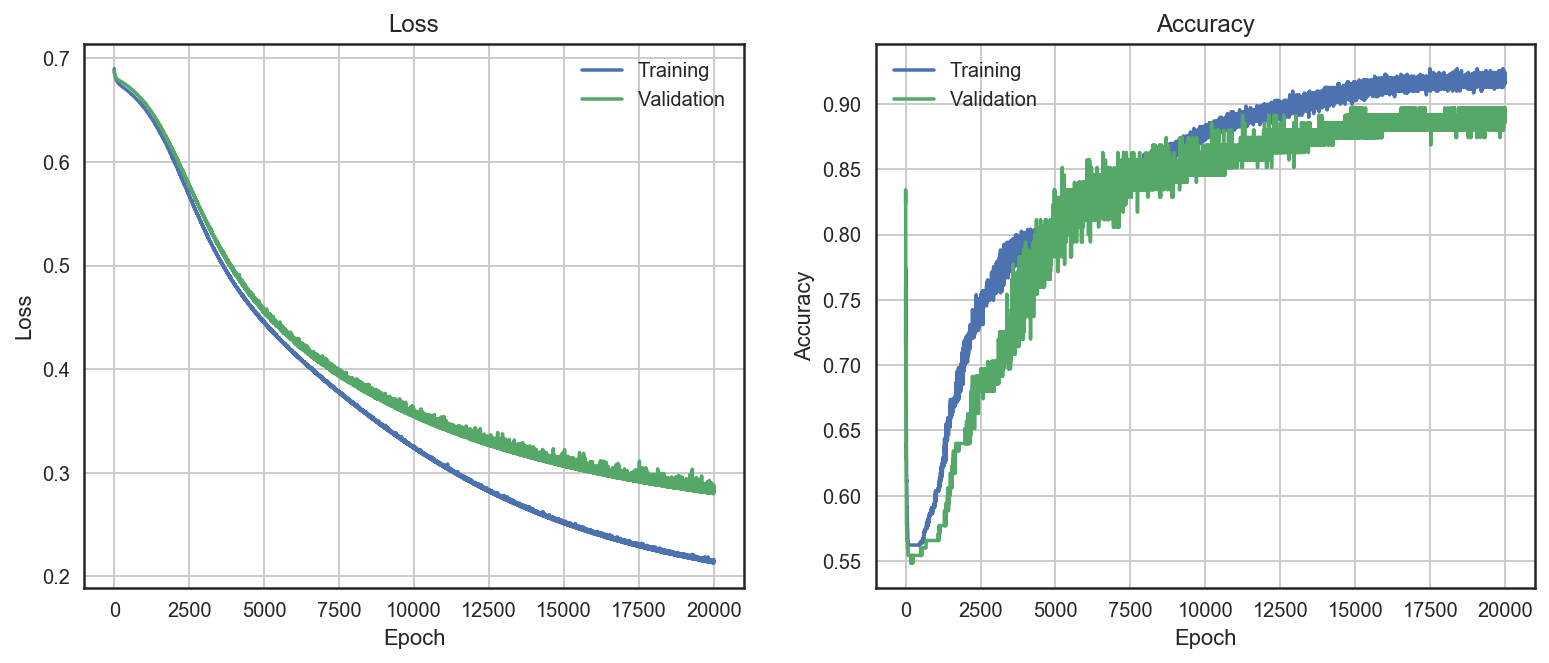

In [52]:
n_rows=1
n_cols=2

plots = ['Loss', 'Accuracy']
fig=plt.figure(figsize=(13,5))

ax=fig.add_subplot(n_rows,n_cols,1)
ax.plot(m_10_16n.epoch, m_10_16n.history['loss'], label='Training');
ax.plot(m_10_16n.epoch, m_10_16n.history['val_loss'], label='Validation');
ax.grid();
ax.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.set_title('Loss');

ax=fig.add_subplot(n_rows,n_cols,2)
ax.plot(m_10_16n.epoch, m_10_16n.history['acc'], label='Training');
ax.plot(m_10_16n.epoch, m_10_16n.history['val_acc'], label='Validation');
ax.grid();
ax.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
ax.set_title('Accuracy');

In [53]:
%%time
# prediction on test data

all_prediction_acc_10_16n = []
keys_both = zip(keys_X, keys_y)

for item in keys_both:
    #print(item)
    prediction_10_16n = model_10_16n.predict_classes(all_X_test_data_10perc[item[0]], verbose=0)
    accuracy = model_10_16n.evaluate(all_X_test_data_10perc[item[0]], all_y_test_onehot[item[1]], verbose=0)                                                             
    
    #print(accuracy[1])
    #print(prediction)
    
    all_prediction_acc_10_16n.append(accuracy[1])

print('The average accuracy on the for 100 30-day-ahead predictions is {}.'.format(np.array(all_prediction_acc_10_16n).mean()))

The average accuracy on the for 100 30-day-ahead predictions is 0.8946666604280472.
CPU times: user 153 ms, sys: 17.7 ms, total: 171 ms
Wall time: 132 ms


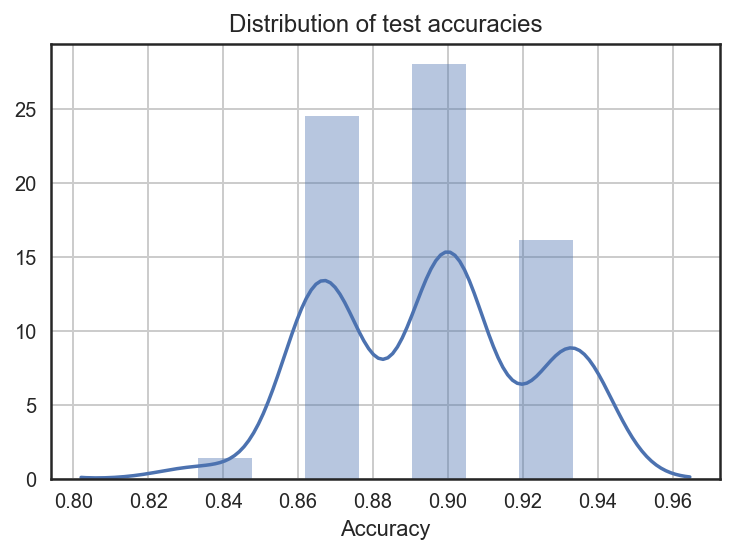

In [54]:
# distribution of test accuracies
x_nn_10_16n = all_prediction_acc_10_16n
sns.distplot(x_nn_10_16n, axlabel='Accuracy')

ax = plt.axes()
ax.set_title('Distribution of test accuracies')
plt.grid()

#### 6.2.2. experiment
10% data, 32 nodes, 128 batch size

In [55]:
# create neural network
input_dims = X_train_10.shape[1]   # number of features that go into the model

model_10_32n = Sequential()
model_10_32n.add(Dense(32, input_shape=(input_dims, ), name='hidden', use_bias=True), )   # units is the number of units in the layer 
model_10_32n.add(Activation('relu'))
model_10_32n.add(Dense(2, name='output', use_bias=False))   # number of output classes
model_10_32n.add(Activation('softmax'))
#sgd = optimizers.SGD(lr=0.01, decay=1e-06, momentum=0.9, nesterov=True)
sgd = optimizers.SGD(lr=0.01, decay=1e-06)
model_10_32n.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [56]:
model_10_32n.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 32)                256       
_________________________________________________________________
activation_3 (Activation)    (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 2)                 64        
_________________________________________________________________
activation_4 (Activation)    (None, 2)                 0         
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________


In [57]:
%%time
m_10_32n = model_10_32n.fit(X_train_10_nn, y_train_onehot, validation_data=(X_validation_10_nn, y_validation_onehot),
              batch_size=128, epochs=20000, shuffle=True, verbose=0)

CPU times: user 4min 8s, sys: 1min 24s, total: 5min 33s
Wall time: 3min 39s


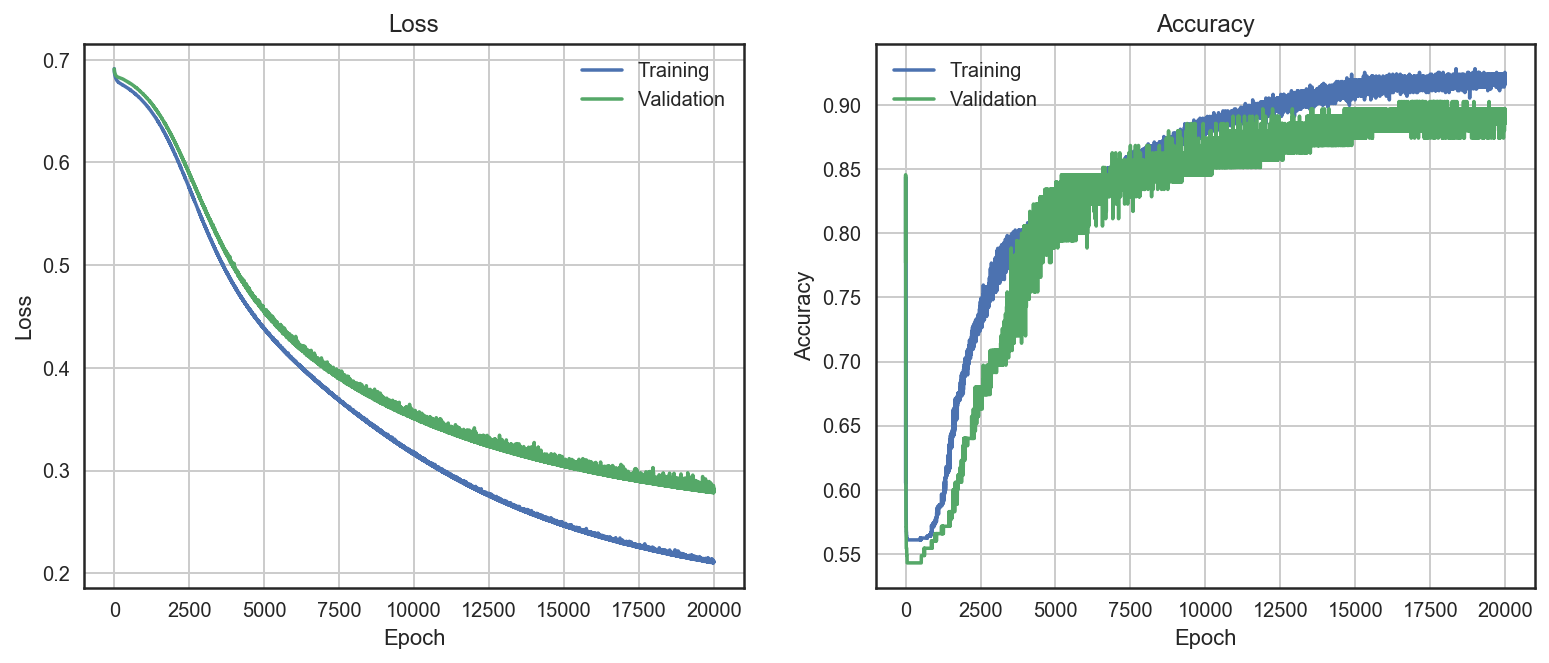

In [58]:
n_rows=1
n_cols=2

plots = ['Loss', 'Accuracy']
fig=plt.figure(figsize=(13,5))

ax=fig.add_subplot(n_rows,n_cols,1)
ax.plot(m_10_32n.epoch, m_10_32n.history['loss'], label='Training');
ax.plot(m_10_32n.epoch, m_10_32n.history['val_loss'], label='Validation');
ax.grid();
ax.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.set_title('Loss');

ax=fig.add_subplot(n_rows,n_cols,2)
ax.plot(m_10_32n.epoch, m_10_32n.history['acc'], label='Training');
ax.plot(m_10_32n.epoch, m_10_32n.history['val_acc'], label='Validation');
ax.grid();
ax.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
ax.set_title('Accuracy');

In [59]:
%%time
# prediction on test data

all_prediction_acc_10_32n = []
keys_both = zip(keys_X, keys_y)

for item in keys_both:
    #print(item)
    prediction_10_32n = model_10_32n.predict_classes(all_X_test_data_10perc[item[0]], verbose=0)
    accuracy = model_10_32n.evaluate(all_X_test_data_10perc[item[0]], all_y_test_onehot[item[1]], verbose=0)                                                             
    
    #print(accuracy[1])
    #print(prediction)
    
    all_prediction_acc_10_32n.append(accuracy[1])

print('The average accuracy on the for 100 30-day-ahead predictions is {}.'.format(np.array(all_prediction_acc_10_32n).mean()))

The average accuracy on the for 100 30-day-ahead predictions is 0.8749999904632568.
CPU times: user 151 ms, sys: 17.5 ms, total: 168 ms
Wall time: 129 ms


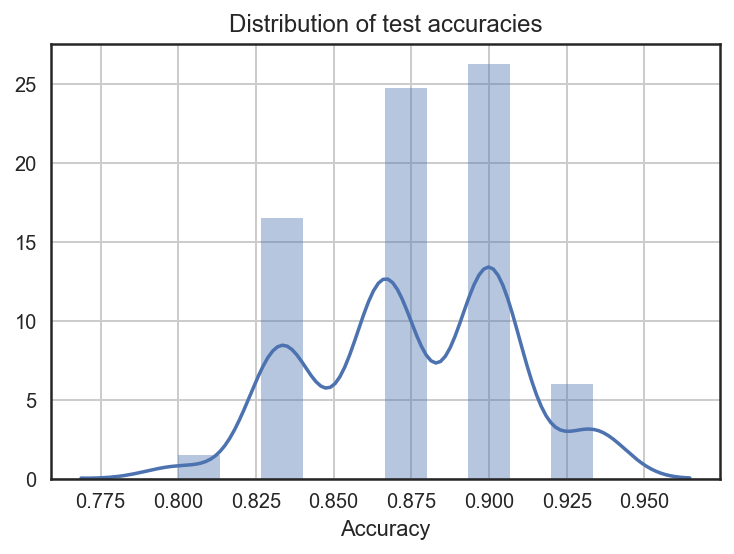

In [60]:
# distribution of test accuracies
x_nn_10_32n = all_prediction_acc_10_32n
sns.distplot(x_nn_10_32n, axlabel='Accuracy')

ax = plt.axes()
ax.set_title('Distribution of test accuracies')
plt.grid()

#### 6.2.3. experiment
25% data, 16 nodes, 128 batch size

In [61]:
# create neural network
input_dims = X_train_25.shape[1]   # number of features that go into the model

model_25_16n = Sequential()
model_25_16n.add(Dense(16, input_shape=(input_dims, ), name='hidden', use_bias=True), )   # units is the number of units in the layer 
model_25_16n.add(Activation('relu'))
model_25_16n.add(Dense(2, name='output', use_bias=False))   # number of output classes
model_25_16n.add(Activation('softmax'))
#sgd = optimizers.SGD(lr=0.01, decay=1e-06, momentum=0.9, nesterov=True)
sgd = optimizers.SGD(lr=0.01, decay=1e-06)
model_25_16n.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [62]:
model_25_16n.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 16)                272       
_________________________________________________________________
activation_5 (Activation)    (None, 16)                0         
_________________________________________________________________
output (Dense)               (None, 2)                 32        
_________________________________________________________________
activation_6 (Activation)    (None, 2)                 0         
Total params: 304
Trainable params: 304
Non-trainable params: 0
_________________________________________________________________


In [63]:
%%time
m_25_16n = model_25_16n.fit(X_train_25_nn, y_train_onehot, validation_data=(X_validation_25_nn, y_validation_onehot),
              batch_size=128, epochs=20000, shuffle=True, verbose=0)

CPU times: user 4min 3s, sys: 1min 20s, total: 5min 24s
Wall time: 3min 34s


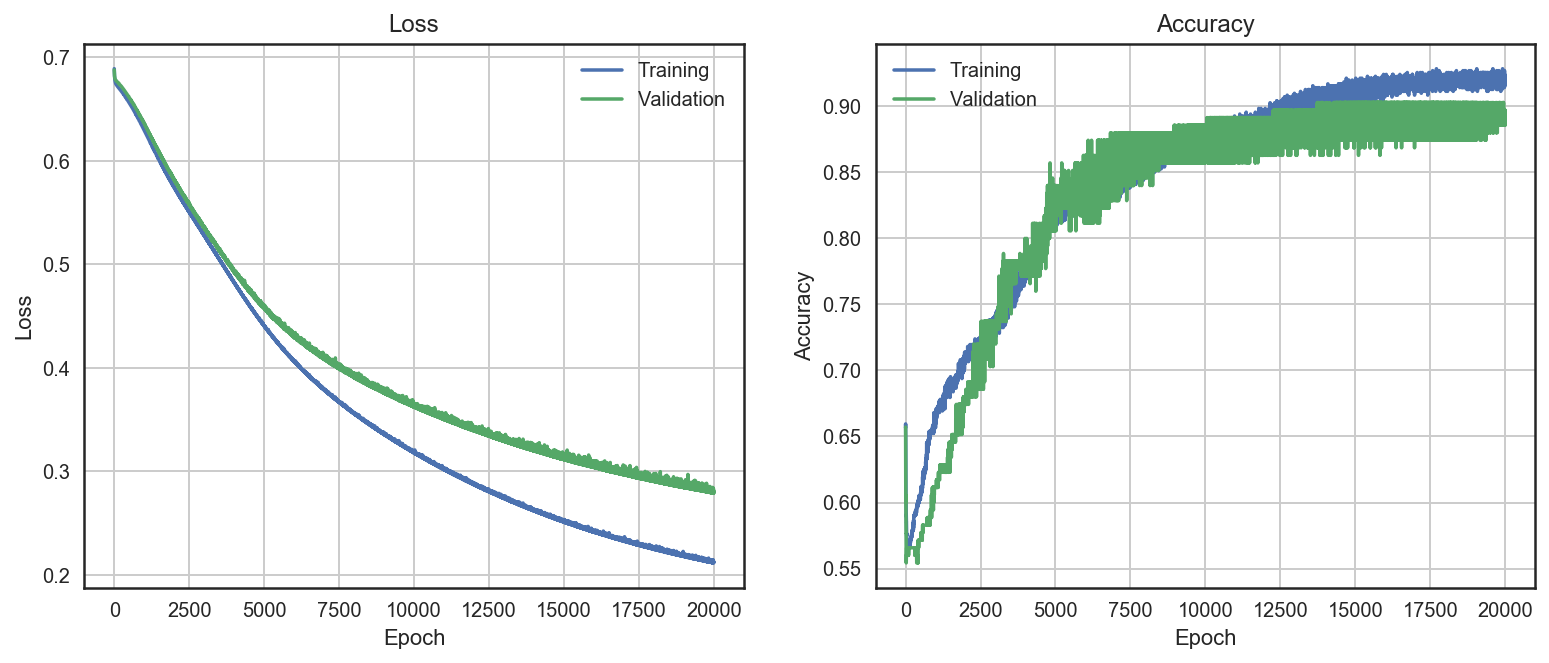

In [64]:
n_rows=1
n_cols=2

plots = ['Loss', 'Accuracy']
fig=plt.figure(figsize=(13,5))

ax=fig.add_subplot(n_rows,n_cols,1)
ax.plot(m_25_16n.epoch, m_25_16n.history['loss'], label='Training');
ax.plot(m_25_16n.epoch, m_25_16n.history['val_loss'], label='Validation');
ax.grid();
ax.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.set_title('Loss');

ax=fig.add_subplot(n_rows,n_cols,2)
ax.plot(m_25_16n.epoch, m_25_16n.history['acc'], label='Training');
ax.plot(m_25_16n.epoch, m_25_16n.history['val_acc'], label='Validation');
ax.grid();
ax.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
ax.set_title('Accuracy');

In [65]:
%%time
# prediction on test data

all_prediction_acc_25_16n = []
keys_both = zip(keys_X, keys_y)

for item in keys_both:
    #print(item)
    prediction_25_16n = model_25_16n.predict_classes(all_X_test_data_25perc[item[0]], verbose=0)
    accuracy = model_25_16n.evaluate(all_X_test_data_25perc[item[0]], all_y_test_onehot[item[1]], verbose=0)                                                             
    
    #print(accuracy[1])
    #print(prediction)
    
    all_prediction_acc_25_16n.append(accuracy[1])

print('The average accuracy on the for 100 30-day-ahead predictions is {}.'.format(np.array(all_prediction_acc_25_16n).mean()))

The average accuracy on the for 100 30-day-ahead predictions is 0.8899999916553497.
CPU times: user 158 ms, sys: 17.7 ms, total: 176 ms
Wall time: 137 ms


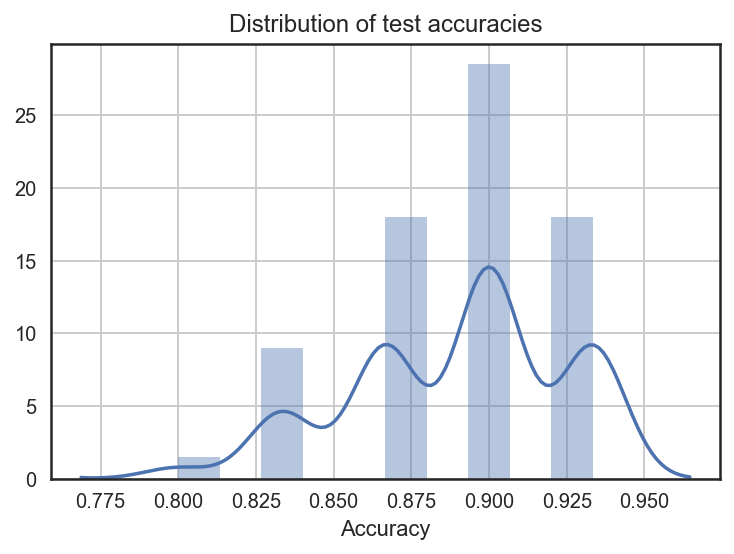

In [66]:
# distribution of test accuracies
x_nn_25_16n = all_prediction_acc_25_16n
sns.distplot(x_nn_25_16n, axlabel='Accuracy')

ax = plt.axes()
ax.set_title('Distribution of test accuracies')
plt.grid()

#### 6.2.4. experiment
25% data, 32 nodes, 128 batch size

In [67]:
# create neural network
input_dims = X_train_25.shape[1]   # number of features that go into the model

model_25_32n = Sequential()
model_25_32n.add(Dense(32, input_shape=(input_dims, ), name='hidden', use_bias=True), )   # units is the number of units in the layer 
model_25_32n.add(Activation('relu'))
model_25_32n.add(Dense(2, name='output', use_bias=False))   # number of output classes
model_25_32n.add(Activation('softmax'))
#sgd = optimizers.SGD(lr=0.01, decay=1e-06, momentum=0.9, nesterov=True)
sgd = optimizers.SGD(lr=0.01, decay=1e-06)
model_25_32n.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [68]:
model_25_32n.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 32)                544       
_________________________________________________________________
activation_7 (Activation)    (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 2)                 64        
_________________________________________________________________
activation_8 (Activation)    (None, 2)                 0         
Total params: 608
Trainable params: 608
Non-trainable params: 0
_________________________________________________________________


In [69]:
%%time
m_25_32n= model_25_32n.fit(X_train_25_nn, y_train_onehot, validation_data=(X_validation_25_nn, y_validation_onehot),
              batch_size=128, epochs=20000, shuffle=True, verbose=0)

CPU times: user 4min 14s, sys: 1min 23s, total: 5min 37s
Wall time: 3min 43s


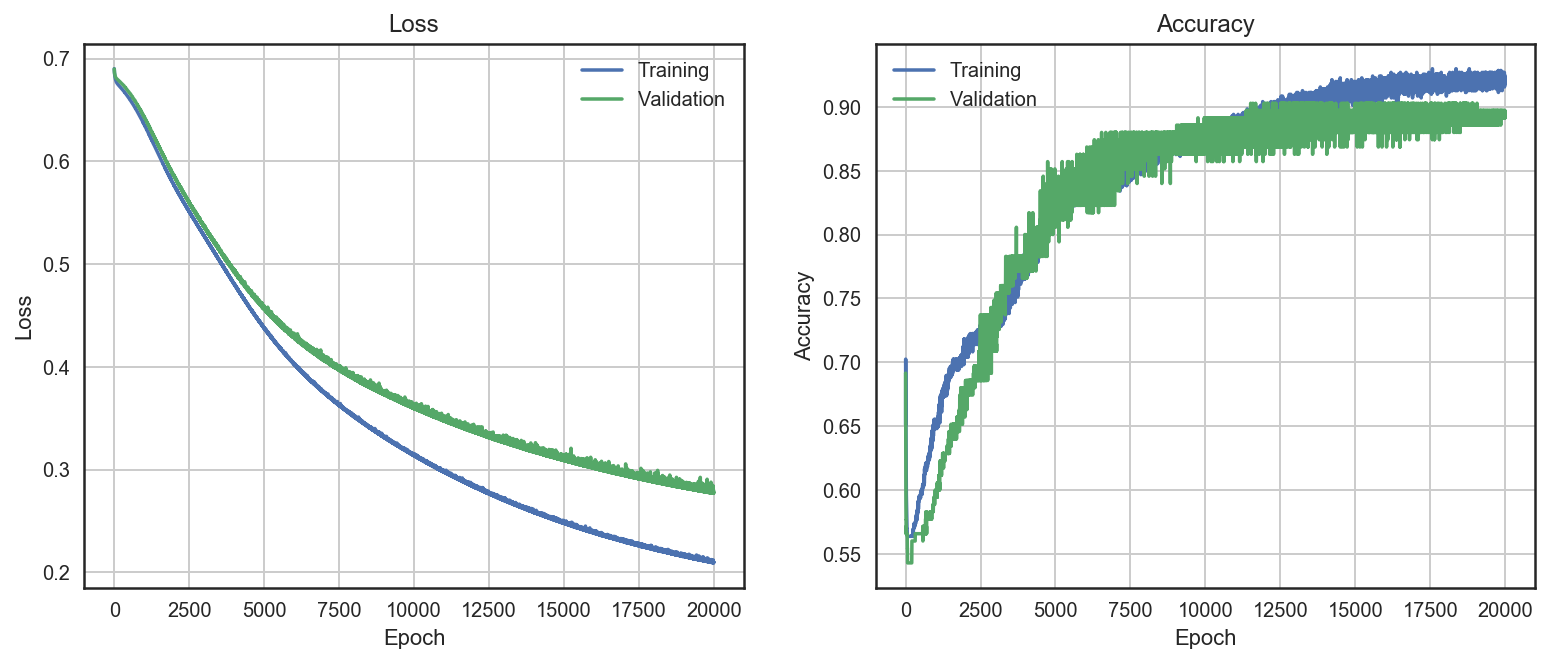

In [70]:
n_rows=1
n_cols=2

plots = ['Loss', 'Accuracy']
fig=plt.figure(figsize=(13,5))

ax=fig.add_subplot(n_rows,n_cols,1)
ax.plot(m_25_32n.epoch, m_25_32n.history['loss'], label='Training');
ax.plot(m_25_32n.epoch, m_25_32n.history['val_loss'], label='Validation');
ax.grid();
ax.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.set_title('Loss');

ax=fig.add_subplot(n_rows,n_cols,2)
ax.plot(m_25_32n.epoch, m_25_32n.history['acc'], label='Training');
ax.plot(m_25_32n.epoch, m_25_32n.history['val_acc'], label='Validation');
ax.grid();
ax.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
ax.set_title('Accuracy');

In [71]:
%%time
# prediction on test data

all_prediction_acc_25_32n = []
keys_both = zip(keys_X, keys_y)

for item in keys_both:
    #print(item)
    prediction_25_32n = model_25_32n.predict_classes(all_X_test_data_25perc[item[0]], verbose=0)
    accuracy = model_25_32n.evaluate(all_X_test_data_25perc[item[0]], all_y_test_onehot[item[1]], verbose=0)                                                             
    
    #print(accuracy[1])
    #print(prediction)
    
    all_prediction_acc_25_32n.append(accuracy[1])

print('The average accuracy on the for 100 30-day-ahead predictions is {}.'.format(np.array(all_prediction_acc_25_32n).mean()))

The average accuracy on the for 100 30-day-ahead predictions is 0.8809999948740006.
CPU times: user 163 ms, sys: 21.6 ms, total: 185 ms
Wall time: 145 ms


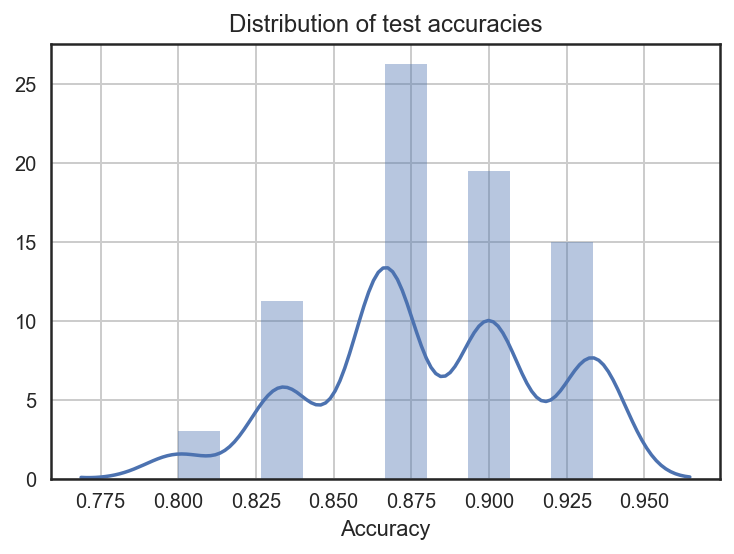

In [72]:
# distribution of test accuracies
x_nn_25_32n = all_prediction_acc_25_32n
sns.distplot(x_nn_25_32n, axlabel='Accuracy', norm_hist=True)

ax = plt.axes()
ax.set_title('Distribution of test accuracies')
plt.grid()

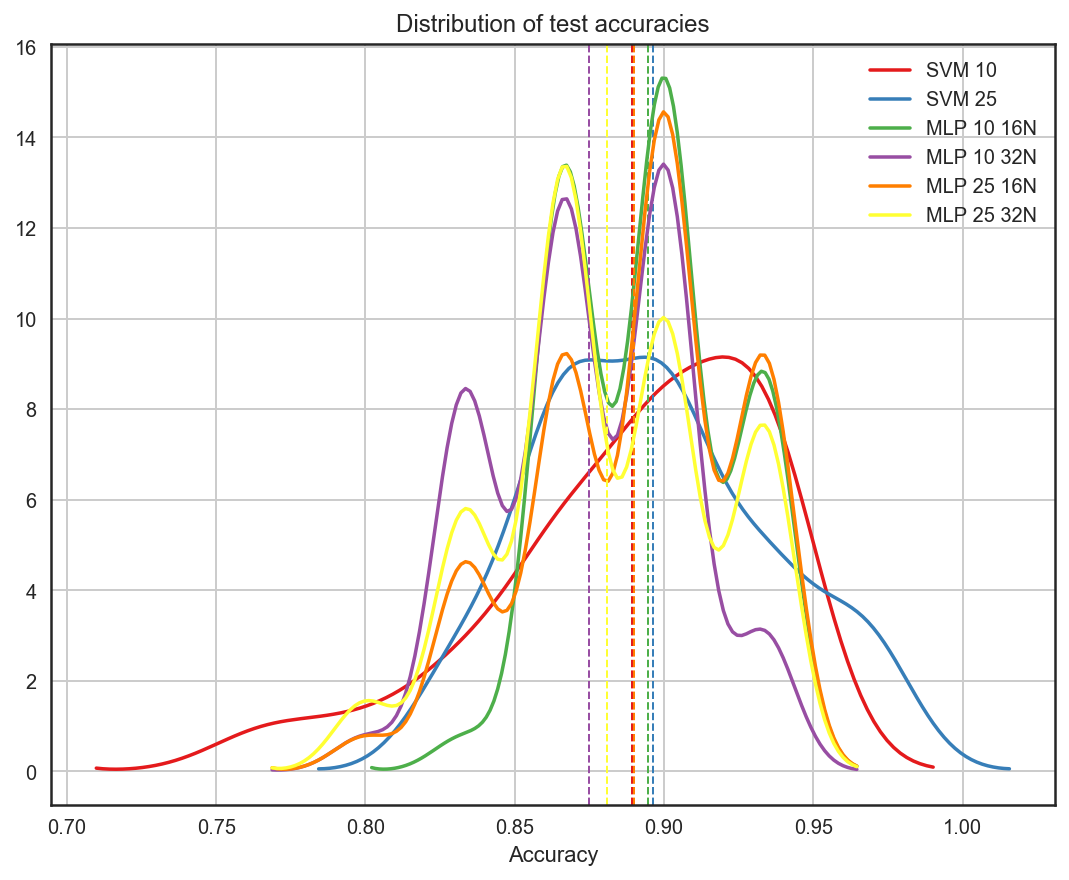

In [73]:
# comparison of robustness of all predictions

colors=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33']
plt.figure(figsize=(9,7))
plt.grid()

sns.distplot(x_svm_10, axlabel='Accuracy', kde_kws={"label": "SVM 10"}, hist=False, color=colors[0])
plt.axvline(np.array(all_prediction_acc_10).mean(), linestyle='dashed', linewidth=1, color=colors[0])
sns.distplot(x_svm_25, axlabel='Accuracy', kde_kws={"label": "SVM 25"}, hist=False, color=colors[1])
plt.axvline(np.array(all_prediction_acc_25).mean(), linestyle='dashed', linewidth=1, color=colors[1])
sns.distplot(x_nn_10_16n, axlabel='Accuracy', kde_kws={"label": "MLP 10 16N"}, hist=False, color=colors[2])
plt.axvline(np.array(all_prediction_acc_10_16n).mean(), linestyle='dashed', linewidth=1, color=colors[2])
sns.distplot(x_nn_10_32n, axlabel='Accuracy', kde_kws={"label": "MLP 10 32N"}, hist=False, color=colors[3])
plt.axvline(np.array(all_prediction_acc_10_32n).mean(), linestyle='dashed', linewidth=1, color=colors[3])
sns.distplot(x_nn_25_16n, axlabel='Accuracy', kde_kws={"label": "MLP 25 16N"}, hist=False, color=colors[4])
plt.axvline(np.array(all_prediction_acc_25_16n).mean(), linestyle='dashed', linewidth=1, color=colors[4])
sns.distplot(x_nn_25_32n, axlabel='Accuracy', kde_kws={"label": "MLP 25 32N"}, hist=False, color=colors[5])
plt.axvline(np.array(all_prediction_acc_25_32n).mean(), linestyle='dashed', linewidth=1, color=colors[5])
plt.title('Distribution of test accuracies');
